In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from fire_model.ca import FireEnv
from dataclasses import dataclass
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import CAFireModel
from fire_model.bo_sr import RetardantDropBayesOptSR, TiedSRDeltaMatern
from fire_model.bo import expected_improvement

# =========================
# Evidence links (used below)
# =========================
# Vic slope rule-of-thumb (CFA Victoria): fire doubles speed for every 10° upslope (and halves downhill).
# https://www.cfa.vic.gov.au/plan-prepare/bushfire-basics/how-fire-behaves
#
# Extreme-day spread rates used as calibration targets (Tolhurst 2009, PHOENIX RapidFire modelling):
# “as fast as 60 km/h in grassland and 40 km/h in forest” (short pulses).
# https://exposed.net.au/tolhurst_2009.pdf
#
# Wind change (“cool change”) context (Australia):
# https://www.sbs.com.au/news/article/whats-the-weather-after-the-heatwave/rhbhojy2l
#
# Barriers like roads/lines can partially stop spread (NWCG S-290 workbook mentions “barriers”).
# https://training.nwcg.gov/dl/s290/s-290-student-workbook-all.pdf
#
# Retardant persistence (manufacturer): effective until a significant rain event.
# https://www.perimeter-solutions.com/en/phos-chek-wildfire-home-defense-faqs/
#
# Drop footprint example (USAF MAFFS): ~1/4 mile long, ~60 ft wide.
# https://www.af.mil/About-Us/Fact-Sheets/Display/Article/104558/modular-airborne-fire-fighting-system/

# ==========================================================
# IMPORTANT: "use slope correctly" requires a tiny model patch
# ==========================================================
# Patch your FireModel step_batch (in fire_model/ca.py) to multiply bias by a slope factor:
#
#   if env.slope is not None:
#       sxg = env.slope[..., 0]   # dz/dx (dimensionless grade)
#       syg = env.slope[..., 1]   # dz/dy
#       grade_along = sxg * ux + syg * uy
#       theta = np.arctan(grade_along) * 180.0 / np.pi
#       theta = np.clip(theta, -30.0, 30.0)
#       slope_factor = np.power(2.0, theta / 10.0)  # CFA: *2 per +10°, /2 per -10°
#       bias *= slope_factor

# =========================
# Scenario: Victoria-style
# =========================
nx = ny = 150
domain_km = 3.0
extent_km = domain_km / 2
dx_m = (domain_km / nx) * 1000.0

xs = np.linspace(-extent_km, extent_km, nx)[:, None]
ys = np.linspace(-extent_km, extent_km, ny)[None, :]
X = xs.repeat(ny, axis=1)
Y = ys.repeat(nx, axis=0)

rng = np.random.default_rng(11)

# ==========================================================
# Common helpers + defaults (kept constant across scenarios)
# ==========================================================
def distance_to_curve(X, Y, pts):
    dmin = np.full(X.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((X - px) ** 2 + (Y - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin

def smooth_noise(rng, nx, ny, iters=6):
    a = rng.normal(size=(nx, ny))
    for _ in range(iters):
        a = (
            0.40 * a
            + 0.10 * np.roll(a, 1, 0) + 0.10 * np.roll(a, -1, 0)
            + 0.10 * np.roll(a, 1, 1) + 0.10 * np.roll(a, -1, 1)
            + 0.05 * np.roll(np.roll(a, 1, 0), 1, 1)
            + 0.05 * np.roll(np.roll(a, -1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(a, 1, 0), -1, 1)
            + 0.05 * np.roll(np.roll(a, -1, 0), 1, 1)
        )
    return (a - a.mean()) / (a.std() + 1e-9)

def make_base_grids(nx=150, ny=150, domain_km=3.0):
    extent_km = domain_km / 2
    xs = np.linspace(-extent_km, extent_km, nx)[:, None]
    ys = np.linspace(-extent_km, extent_km, ny)[None, :]
    X = xs.repeat(ny, axis=1)
    Y = ys.repeat(nx, axis=0)
    dx_m = (domain_km / nx) * 1000.0
    return xs, ys, X, Y, dx_m

def constant_wind(nx, ny, u=12.0, v=3.0):
    # Constant wind (no dir change) so your plot_env works without special handling.
    # Shape: (T, nx, ny, 2) because your plot_env expects time dimension.
    T = 200  # arbitrary timeline length for plotting
    w = np.zeros((T, nx, ny, 2), dtype=float)
    w[..., 0] = u
    w[..., 1] = v
    return w, T // 2  # phase1_steps is only used for snapshot indices

# -----------------------------------
# Helper: distance-to-polyline (sampled)
# -----------------------------------
def distance_to_curve(xgrid, ygrid, pts):
    dmin = np.full(xgrid.shape, np.inf, dtype=float)
    for px, py in pts:
        d = np.sqrt((xgrid - px) ** 2 + (ygrid - py) ** 2)
        dmin = np.minimum(dmin, d)
    return dmin

# ==========================================================
# 1) Terrain: valley + gentle hills + stochastic relief
# ==========================================================
raw = rng.normal(size=(nx, ny))
smooth = raw.copy()
for _ in range(6):
    smooth = (
        0.40 * smooth
        + 0.10 * np.roll(smooth, 1, 0) + 0.10 * np.roll(smooth, -1, 0)
        + 0.10 * np.roll(smooth, 1, 1) + 0.10 * np.roll(smooth, -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), 1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), -1, 1)
        + 0.05 * np.roll(np.roll(smooth, 1, 0), -1, 1)
        + 0.05 * np.roll(np.roll(smooth, -1, 0), 1, 1)
    )
smooth = (smooth - smooth.mean()) / (smooth.std() + 1e-9)

valley = -95.0 * np.exp(-((Y + 0.05) ** 2) / 0.35)
upland = 65.0 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
west_rise = 40.0 * (1.0 / (1.0 + np.exp((X - 0.3) / 0.55)))  # higher to the west

elev_m = 190.0 + valley + upland + west_rise + 18.0 * smooth
elev_m = np.clip(elev_m, 80.0, 360.0)

# ==========================================================
# 2) River (vertical squiggly)
# ==========================================================
rt = np.linspace(-extent_km, extent_km, 260)
river_x0 = -0.45
river_x = river_x0 + 0.22 * np.sin(0.75 * rt) + 0.08 * np.sin(2.3 * rt)
river_y = rt
river_pts = np.stack([river_x, river_y], axis=1)
d_river = distance_to_curve(X, Y, river_pts)

river_mask = d_river < 0.035
riparian_mask = d_river < 0.095

elev_m = elev_m - 14.0 * np.exp(-(d_river**2) / (2 * 0.030**2))
elev_m = np.clip(elev_m, 70.0, 360.0)

# Slope
dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

# ==========================================================
# 3) Two main towns (as before)
# ==========================================================
flat = slope_deg < 6.0
not_water = ~river_mask

cand0 = flat & not_water & (np.abs(Y) < 0.85) & (d_river > 0.07) & (d_river < 0.20) & (X < 0.5)
cand1 = flat & not_water & (np.abs(Y) < 0.90) & (d_river > 0.35) & (X > 0.6)

def pick_town(mask, prefer_x, prefer_y=0.0):
    score = mask.astype(float)
    score *= np.exp(-(slope_deg**2) / (2 * 4.0**2))
    score *= np.exp(-((Y - prefer_y)**2) / (2 * 0.60**2))
    score *= np.exp(-((X - prefer_x)**2) / (2 * 0.80**2))
    i, j = np.unravel_index(np.argmax(score), score.shape)
    return (i, j)

town0 = pick_town(cand0, prefer_x=-0.2, prefer_y=0.1)   # near river
town1 = pick_town(cand1, prefer_x=+0.5 * extent_km, prefer_y=-0.1)  # east valley terrace

# ==========================================================
# 4) Roads
ROAD_FUEL_FACTOR = 0.10  # roads are burnable but much less likely to carry fire
#    - Main highway E-W
#    - NW feeder now EXTENDS to the map edge (your request)
#    - Two short town connectors
# ==========================================================
t = np.linspace(-extent_km, extent_km, 260)
hw_pts = np.stack([t, -0.10 + 0.22 * np.sin(0.55 * t)], axis=1)
d_hw = distance_to_curve(X, Y, hw_pts)

# Junction on highway west of river
junction_x = river_x0 - 0.55
k_j = int(np.argmin(np.abs(hw_pts[:, 0] - junction_x)))
junction = hw_pts[k_j]

# NW feeder: explicitly runs from TOP-LEFT edge down to the junction (full extent)
# Start at (x=-extent_km, y=+extent_km) which is the top-left boundary in our coord system.
s = np.linspace(0.0, 1.0, 340)
nw_start = np.array([-extent_km, extent_km])
feeder = (1 - s)[:, None] * nw_start + s[:, None] * junction
feeder[:, 1] += 0.24 * np.sin(np.pi * s)  # gentle curve
d_feeder = distance_to_curve(X, Y, feeder)

def nearest_point(poly_pts, p):
    d = np.sqrt((poly_pts[:, 0] - p[0]) ** 2 + (poly_pts[:, 1] - p[1]) ** 2)
    return poly_pts[int(np.argmin(d))]

def connector(town_xy, hw_pts, bend_sign, n=160):
    hx, hy = nearest_point(hw_pts, town_xy)
    s = np.linspace(0.0, 1.0, n)
    x = (1 - s) * town_xy[0] + s * hx
    y = (1 - s) * town_xy[1] + s * hy + 0.10 * np.sin(np.pi * s) * bend_sign
    return np.stack([x, y], axis=1)

town0_xy = (xs[town0[0], 0], ys[0, town0[1]])
town1_xy = (xs[town1[0], 0], ys[0, town1[1]])

conn0 = connector(town0_xy, hw_pts, bend_sign=+1.0)
conn1 = connector(town1_xy, hw_pts, bend_sign=-1.0)
d_conn0 = distance_to_curve(X, Y, conn0)
d_conn1 = distance_to_curve(X, Y, conn1)

road_mask = (d_hw < 0.045) | (d_feeder < 0.040) | (d_conn0 < 0.030) | (d_conn1 < 0.030)

# ==========================================================
# 5) Add a small town near the LEFT road (NW feeder)
#    - Small settlement along the feeder, flat-ish, not on river.
# ==========================================================
# Pick candidate pixels near feeder, away from junction, away from river, and relatively flat.
near_feeder = (d_feeder > 0.02) & (d_feeder < 0.10)
away_from_junction = np.sqrt((X - junction[0])**2 + (Y - junction[1])**2) > 0.9
cand_small = flat & not_water & near_feeder & away_from_junction & (X < -1.4) & (Y > 0.6)

small_town = pick_town(cand_small, prefer_x=(-2.2 / 3.2) * extent_km, prefer_y=0.5 * extent_km)

# Flatten pads for all towns (built environments)
for (ti, tj) in [town0, town1, small_town]:
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    pad = np.exp(-r2 / (2 * 0.18**2))
    elev_m = (1.0 - 0.60 * pad) * elev_m + (0.60 * pad) * elev_m[ti, tj]

# Recompute slope after flattening
dzdx = np.gradient(elev_m, dx_m, axis=0)
dzdy = np.gradient(elev_m, dx_m, axis=1)
slope = np.stack([dzdx, dzdy], axis=-1)
slope_deg = np.degrees(np.arctan(np.sqrt(dzdx**2 + dzdy**2)))

town_centers = [town0, town1, small_town]

# ==========================================================
# 6) Fuels
# ==========================================================
fuel = 0.85 * np.ones((nx, ny), dtype=float)
upland_fuel = 1.05 * (1.0 - np.exp(-((Y + 0.05) ** 2) / 1.10))
fuel += upland_fuel

patch = rng.normal(size=(nx, ny))
for _ in range(4):
    patch = 0.60 * patch + 0.10 * np.roll(patch, 1, 0) + 0.10 * np.roll(patch, -1, 0) + 0.10 * np.roll(patch, 1, 1) + 0.10 * np.roll(patch, -1, 1)
patch = (patch - patch.mean()) / (patch.std() + 1e-9)
fuel *= (1.0 + 0.08 * patch)

# Roads reduce fuel (barrier effect).
# Evidence: barriers can partially stop spread (NWCG S-290).
# https://training.nwcg.gov/dl/s290/s-290-student-workbook-all.pdf
fuel *= np.where(road_mask, ROAD_FUEL_FACTOR, 1.0)
fuel *= np.where(river_mask, 0.05, 1.0)
fuel *= np.where(riparian_mask & (~river_mask), 0.75, 1.0)
fuel = np.clip(fuel, 0.05, 3.10)
# Make hard barriers truly non-burnable
nonburnable = river_mask  # add riparian_mask too if you want it non-burnable
fuel[nonburnable] = 0.0

# ==========================================================
# 7) Values-at-risk (town0 slightly bigger; small town modest)
# ==========================================================
value = np.ones((nx, ny), dtype=float)

def add_town_value(center, core_amp, core_sigma, wui_amp, wui_sigma):
    ti, tj = center
    cx = xs[ti, 0]
    cy = ys[0, tj]
    r2 = (X - cx) ** 2 + (Y - cy) ** 2
    return core_amp * np.exp(-r2 / core_sigma) + wui_amp * np.exp(-r2 / wui_sigma)

# Town 0 (near river): slightly bigger / higher value
value += add_town_value(town0, core_amp=11.0, core_sigma=0.085, wui_amp=3.2, wui_sigma=0.26)
# Town 1
value += add_town_value(town1, core_amp=8.0, core_sigma=0.08, wui_amp=3.0, wui_sigma=0.25)
# Small town near feeder: modest
value += add_town_value(small_town, core_amp=5.5, core_sigma=0.07, wui_amp=2.0, wui_sigma=0.20)

value += 0.8 * road_mask.astype(float)
value += 1.2 * (riparian_mask & (~river_mask)).astype(float)

# ==========================================================
# 8) Wind: NW prefrontal + SW cool change
# ==========================================================
# Wind change evidence context:
# https://www.sbs.com.au/news/article/whats-the-weather-after-the-heatwave/rhbhojy2l
#
# NOTE: wind_coeff has units 1/(m/s) in your model form: bias = 1 + wind_coeff * max(0, align)
dt_s = 10.0
T_hours = 6.0
num_steps = int(T_hours * 3600 / dt_s)

wind = np.zeros((num_steps, nx, ny, 2), dtype=float)

phase1_steps = int(4.0 * 3600 / dt_s)
w1 = 15.0
wind[:phase1_steps, ..., 0] = +w1 / np.sqrt(2)
wind[:phase1_steps, ..., 1] = -w1 / np.sqrt(2)

w2 = 12.0
wind[phase1_steps:, ..., 0] = +w2 / np.sqrt(2)
wind[phase1_steps:, ..., 1] = +w2 / np.sqrt(2)

gust = rng.normal(0.0, 1.0, size=(num_steps, 1, 1, 2))
wind *= (1.0 + 0.10 * gust)
wind = np.clip(wind, -25.0, 25.0)

# ==========================================================
# 9) Retardant + ROS
# ==========================================================
# Retardant persistence evidence: effective until significant rain event.
# https://www.perimeter-solutions.com/en/phos-chek-wildfire-home-defense-faqs/
#
# MAFFS footprint example: ~1/4 mile long (~0.4 km), ~60 ft wide (~18 m)
# https://www.af.mil/About-Us/Fact-Sheets/Display/Article/104558/modular-airborne-fire-fighting-system/
drop_w_km = 0.04

drop_h_km = 0.40

# Tolhurst calibration targets:
# https://exposed.net.au/tolhurst_2009.pdf
realistic_env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    fuel=fuel,
    value=value,
    wind=wind,
    slope=slope,  # <-- only affects spread if you applied the slope patchs
    dt_s=dt_s,

    burn_time_s0=900.0,

    retardant_half_life_s=172800.0,
    retardant_k=20.0,

    drop_w_km=drop_w_km,
    drop_h_km=drop_h_km,
    drop_amount=2.0,

    ros_mps=0.06,
    wind_coeff=0.04,

    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.1,

    ros_future_jitter_frac=0.05,
    wind_coeff_future_jitter_frac=0.005,
)


### Visualization & Evaluation Helpers

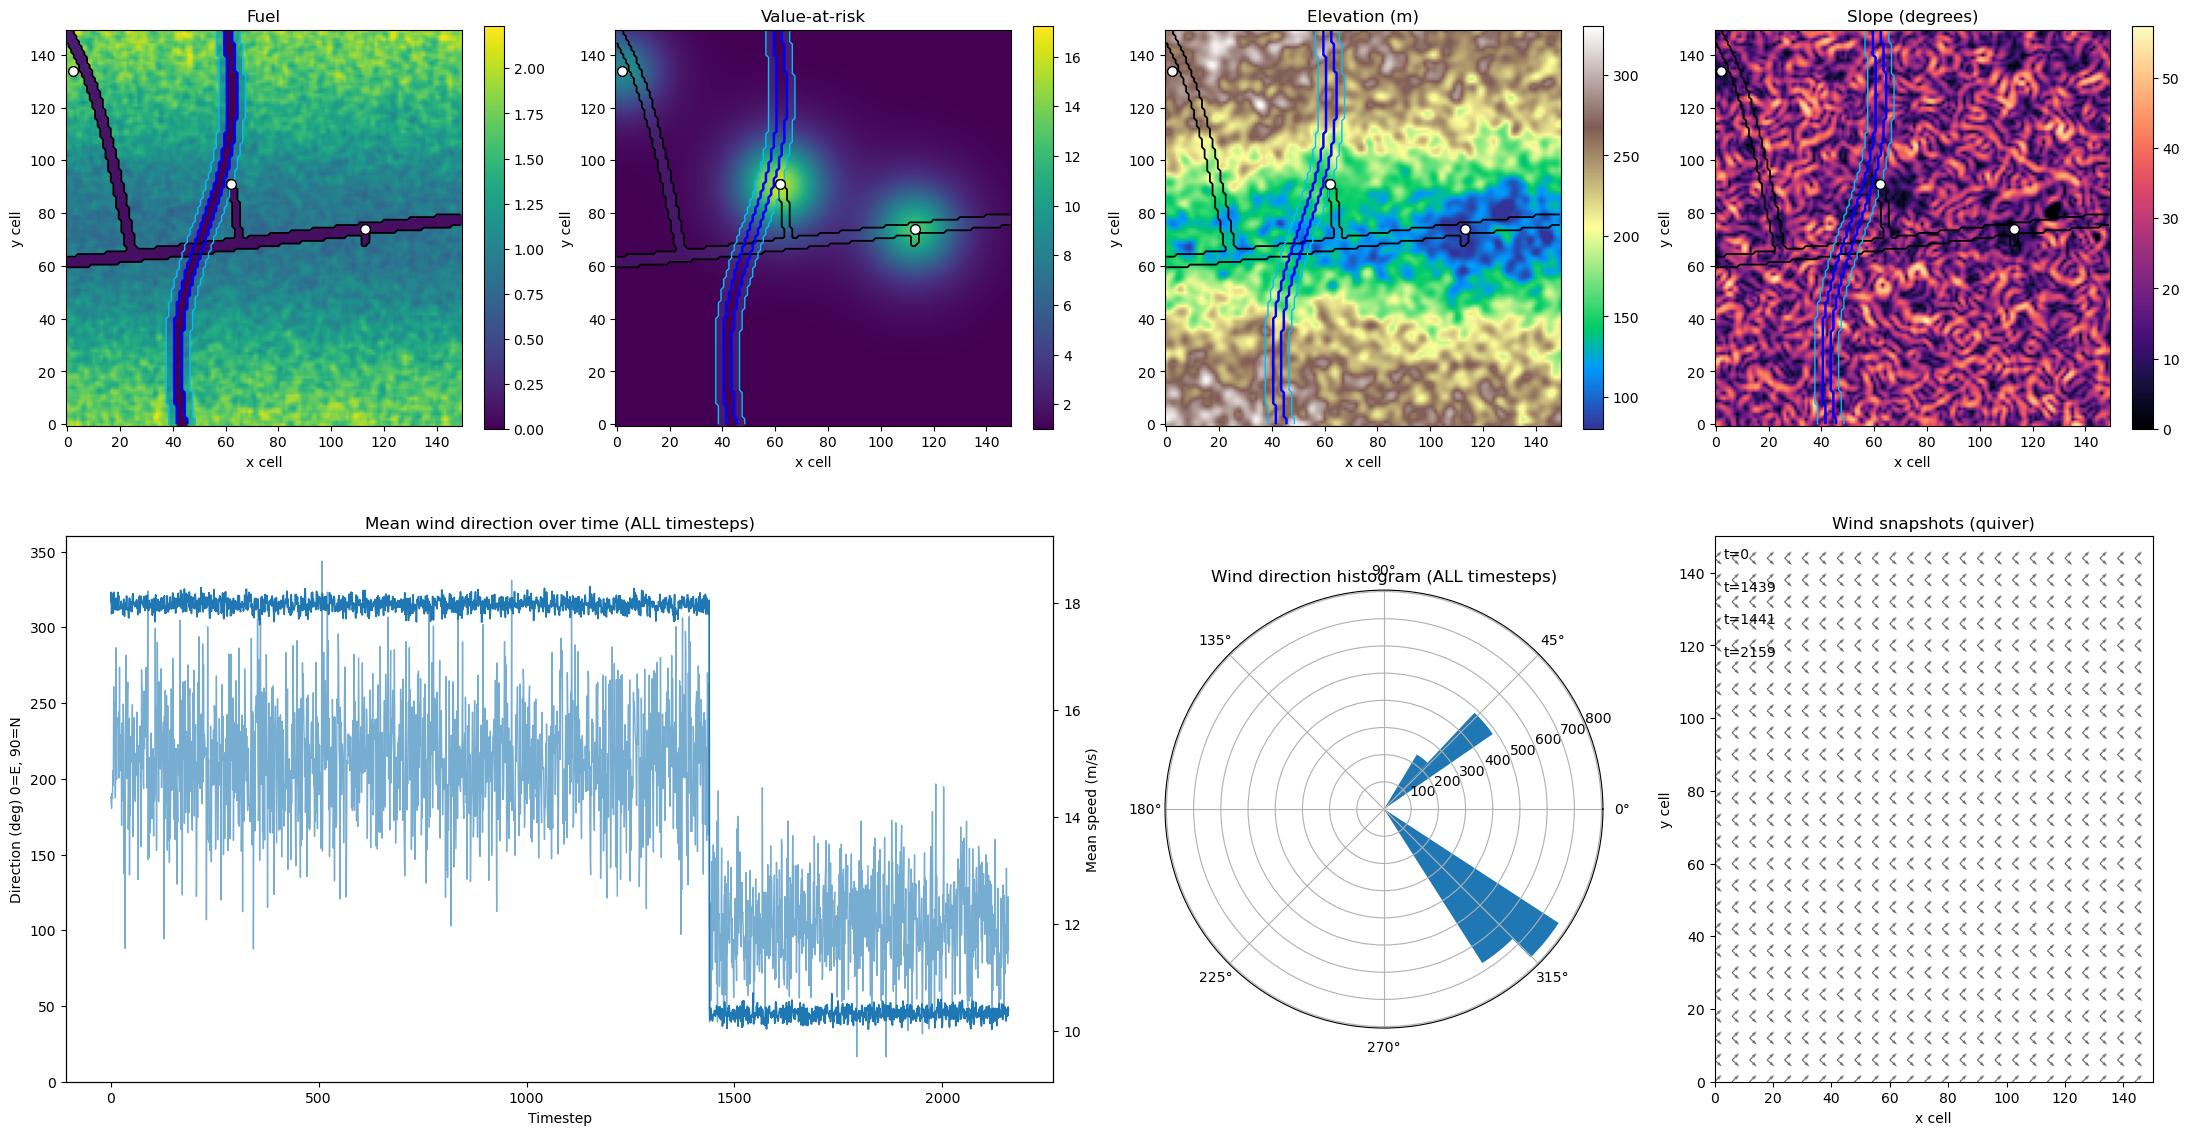

In [2]:

# ==========================================================
# Visualisation (river clearly visible)
# ==========================================================
def plot_env(env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask, phase1_steps):
    fuel = np.asarray(env.fuel, float)
    value = np.asarray(env.value, float)
    wind = np.asarray(env.wind, float)

    slope = np.asarray(slope)
    slope_deg = np.degrees(np.arctan(np.sqrt(slope[..., 0] ** 2 + slope[..., 1] ** 2)))

    mean_vec = wind.reshape(wind.shape[0], -1, 2).mean(axis=1)
    u = mean_vec[:, 0]
    v = mean_vec[:, 1]
    spd = np.sqrt(u**2 + v**2)
    # Math convention: direction vector points TO (0°=East, 90°=North)
    wdir = (np.degrees(np.arctan2(v, u)) + 360.0) % 360.0

    snaps = [0, max(0, phase1_steps - 1), min(len(wdir) - 1, phase1_steps + 1), len(wdir) - 1]
    snaps = sorted(set(snaps))

    fig = plt.figure(figsize=(22, 12))
    gs = fig.add_gridspec(2, 4)

    def overlay(ax):
        # Roads: black contour
        ax.contour(road_mask.T.astype(float), levels=[0.5], linewidths=1.3, colors="k")
        # Riparian: blue dashed
        ax.contour(riparian_mask.T.astype(float), levels=[0.5], linewidths=1.0, colors="deepskyblue")
        # River channel: solid blue
        ax.contour(river_mask.T.astype(float), levels=[0.5], linewidths=1.8, colors="blue")
        for (ti, tj) in town_centers:
            ax.plot(ti, tj, "wo", ms=7, mec="k")
        ax.set_xlabel("x cell")
        ax.set_ylabel("y cell")

    ax = fig.add_subplot(gs[0, 0])
    im = ax.imshow(fuel.T, origin="lower")
    ax.set_title("Fuel")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[0, 1])
    im = ax.imshow(value.T, origin="lower", cmap="viridis")
    ax.set_title("Value-at-risk")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[0, 2])
    im = ax.imshow(elev_m.T, origin="lower", cmap="terrain")
    ax.set_title("Elevation (m)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[0, 3])
    im = ax.imshow(slope_deg.T, origin="lower", cmap="magma")
    ax.set_title("Slope (degrees)")
    fig.colorbar(im, ax=ax, fraction=0.046)
    overlay(ax)

    ax = fig.add_subplot(gs[1, 0:2])
    ax.plot(wdir, lw=1.2)
    ax.set_title("Mean wind direction over time (ALL timesteps)")
    ax.set_ylabel("Direction (deg) 0=E, 90=N")
    ax.set_xlabel("Timestep")
    ax.set_ylim(0, 360)
    ax2 = ax.twinx()
    ax2.plot(spd, lw=1.0, alpha=0.6)
    ax2.set_ylabel("Mean speed (m/s)")

    ax = fig.add_subplot(gs[1, 2], projection="polar")
    ax.hist(np.radians(wdir), bins=24)
    ax.set_title("Wind direction histogram (ALL timesteps)")

    ax = fig.add_subplot(gs[1, 3])
    ax.set_title("Wind snapshots (quiver)")
    skip = max(1, env.grid_size[0] // 22)
    XX = np.arange(0, env.grid_size[0], skip)
    YY = np.arange(0, env.grid_size[1], skip)

    for k, s in enumerate(snaps):
        wf = wind[s][::skip, ::skip]
        ax.quiver(XX, YY, wf[..., 0].T, wf[..., 1].T, alpha=0.35)
        ax.text(0.02, 0.98 - 0.06 * k, f"t={s}", transform=ax.transAxes, va="top")

    ax.set_xlim(0, env.grid_size[0])
    ax.set_ylim(0, env.grid_size[1])
    ax.set_xlabel("x cell")
    ax.set_ylabel("y cell")

    plt.tight_layout()

env_realistic_bundle = realistic_env, elev_m, slope, town_centers, road_mask, river_mask, riparian_mask, phase1_steps

plot_env(
    realistic_env,
    elev_m=elev_m,
    slope=slope,
    town_centers=town_centers,
    road_mask=road_mask,
    river_mask=river_mask,
    riparian_mask=riparian_mask,
    phase1_steps=phase1_steps,
)

In [3]:
def pack_env(fuel, value, wind, slope, nx, ny, domain_km, dt_s=10.0):
    return FireEnv(
        grid_size=(nx, ny),
        domain_km=domain_km,
        fuel=fuel,
        value=value,
        wind=wind,
        slope=slope,  
        dt_s=dt_s,
        burn_time_s0=900.0,
        retardant_half_life_s=172800.0,  # long half-life to mimic persistence-until-rain (given exponential decay)
        retardant_k=20.0,
        drop_w_km=0.05,
        drop_h_km=0.60,
        drop_amount=2.0,
        ros_mps=0.05,
        wind_coeff=0.04,
        diag=True,
        avoid_burning_drop=True,
        avoid_drop_p_threshold=0.1,
        ros_future_jitter_frac=0.05,
        wind_coeff_future_jitter_frac=0.005,
    )

In [4]:
@dataclass
class ScenarioBundle:
    name: str
    env: object
    elev_m: np.ndarray
    slope: np.ndarray
    town_centers: list
    road_mask: np.ndarray
    river_mask: np.ndarray
    riparian_mask: np.ndarray
    phase1_steps: int


def bundle_from_tuple(name, t):
    env, elev_m, slope, towns, roads, river, riparian, phase = t
    return ScenarioBundle(
        name=name,
        env=env,
        elev_m=elev_m,
        slope=slope,
        town_centers=towns,
        road_mask=roads,
        river_mask=river,
        riparian_mask=riparian,
        phase1_steps=phase,
    )

SCENARIOS = [
    bundle_from_tuple("Realistic environment", env_realistic_bundle)
]

# ---- fast settings for interactive testing ----
BO_N_INIT = 30
BO_N_ITERS = 170
BO_N_CANDIDATES = 5000
FIDELITY_LOW = 10
FIDELITY_HIGH = 25
DROP_TIME_S = 15 * 60
SEARCH_GRID_EVOLUTION_TIME_S = 15 * 60
EVOLUTION_TIME_S = 15 * 60
IGNITION_RADIUS_KM = 0.25
IGNITION_CENTER_FRAC = (0.42, 0.25)
N_DRONES = 5
FIRE_BOUNDARY_P = 0.25
SEARCH_GRID_K = 200
SEARCH_GRID_BOUNDARY_FIELD = "affected"

# Pick one scenario index to run interactively:
SCENARIO_IDX = 0  # change this (0..len(SCENARIOS)-1)

bundle = SCENARIOS[SCENARIO_IDX]
print("Scenario:", bundle.name)

# --- BO multifidelity (cheap BO, expensive validate) ---
bo_kwargs = dict(
    n_init=BO_N_INIT,
    n_iters=BO_N_ITERS,
    n_candidates=BO_N_CANDIDATES,
    xi=0.03,
    use_ard_kernel=False,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=6,
    candidate_local_sigma_s=0.03,
    candidate_local_sigma_r=0.03,
    candidate_local_sigma_delta_rad=np.deg2rad(9.0),
    candidate_local_resample_delta_prob=0.05,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.2,
    init_heuristic_kwargs={"value_power": 2.4},
    init_heuristic_mix_prob=0.3,
    init_value_r_offset=-0.02,
    init_value_jitter_delta_rad=np.deg2rad(8.0),
    init_uniform_ring_jitter_s=0.15,
    init_uniform_ring_jitter_r=0.05,
    init_downwind_line_wind_bias=3.0,
    init_downwind_line_jitter_r=0.2,
    init_heuristic_value_prob=0.5,
    init_heuristic_uniform_ring_prob=0.0,
    init_heuristic_downwind_prob=0.5,
)


Scenario: Realistic environment


In [5]:
# --- BO setup (SR search) ---
fire_model = CAFireModel(bundle.env, seed=0)
nx, ny = bundle.env.grid_size
ignition_center = (int(IGNITION_CENTER_FRAC[0] * nx), int(IGNITION_CENTER_FRAC[1] * ny))
init_firestate = fire_model.init_state_batch(
    n_sims=FIDELITY_LOW,
    center=ignition_center,
    radius_km=IGNITION_RADIUS_KM,
)

# Decision-time firestate (retardant drops at DROP_TIME_S)
drop_firestate = fire_model.simulate_from_firestate(
    init_firestate,
    T=DROP_TIME_S,
    n_sims=FIDELITY_LOW,
    drone_params=None,
    ros_mps=fire_model.env.ros_mps,
    wind_coeff=fire_model.env.wind_coeff,
    diag=fire_model.env.diag,
    seed=0,
    avoid_burning_drop=fire_model.env.avoid_burning_drop,
    burning_prob_threshold=fire_model.env.avoid_drop_p_threshold,
)

bo = RetardantDropBayesOptSR(
    fire_model=fire_model,
    init_firestate=drop_firestate,
    n_drones=N_DRONES,
    evolution_time_s=EVOLUTION_TIME_S - DROP_TIME_S,
    n_sims=FIDELITY_LOW,
    fire_boundary_probability=FIRE_BOUNDARY_P,
    search_grid_evolution_time_s=SEARCH_GRID_EVOLUTION_TIME_S - DROP_TIME_S,
)

bo.setup_search_grid_sr(
    K=SEARCH_GRID_K,
    boundary_field=SEARCH_GRID_BOUNDARY_FIELD,
    n_r=150,
    smooth_iters=200,
    omega=1.0,
)

best_theta, best_params, best_y, history, y_nexts, y_bests = bo.run_bayes_opt(
    **bo_kwargs,
    K_grid=SEARCH_GRID_K,
    boundary_field=SEARCH_GRID_BOUNDARY_FIELD,
    n_r=150,
    smooth_iters=200,
    omega=1.0,
    verbose=True,
)
print("Best objective (expected value burned) =", best_y)

# Decode to cartesian for plotting/simulation
best_params_cart = bo.decode_theta(best_theta)


No drone_params
No drone_params
[BO SR] init: n_init=30, dim=15
[BO SR] init: best_y=0.899073, mean_y=0.899073, std_y=2.22045e-16


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 001/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.21e-19
      proposed (s,r,delta) per drone:
      [[0.06281762 0.31415404 2.38695881]
 [0.07998665 0.75662566 3.86063368]
 [0.36627364 0.41503891 6.24261627]
 [0.43755326 0.04716194 2.4905237 ]
 [0.66534377 0.04146605 4.34398922]]
      proposed (x,y,phi) per drone:
      [[48.94238914 49.50195209  4.94875625]
 [50.38105106 49.50487291  5.6498782 ]
 [59.96656257  3.29826714  6.00369007]
 [91.5567214  36.65595324  0.61155576]
 [92.51202787 33.52938611  2.82213312]]
      gp.kernel_ = 0.371**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 002/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=4.77e-19
      proposed (s,r,delta) per drone:
      [[0.04739894 0.67277995 4.00015377]
 [0.0608528  0.38204642 2.81889297]
 [0.15074036 0.68085599 0.02375949]
 [0.86970611 0.42922588 2.67446123]
 [0.97863594 0.34637692 3.56355264]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  5.58554967]
 [89.61170742 15.62974073  2.69492716]
 [90.21006846 16.486615    1.73547284]
 [91.5567214  36.65595324  0.1796216 ]
 [92.51202787 33.52938611  2.68261304]]
      gp.kernel_ = 0.364**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 003/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.42e-192 | mu=0.899073 | std=0.00103
      proposed (s,r,delta) per drone:
      [[0.2818244  0.01837831 2.76383994]
 [0.39987168 0.10715692 3.04145263]
 [0.84051067 0.15219633 3.68957135]
 [0.91812654 0.06289356 3.51965279]
 [0.94215155 0.91406809 1.93872605]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   3.91732413]
 [56.39280328 54.50647973  4.54839887]
 [89.58793373 15.58295567  1.52456406]
 [90.42978546 16.34530965  0.45268503]
 [93.50149913 26.55092397  4.31888893]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 004/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=8.04e-193 | mu=0.899073 | std=0.00103
      proposed (s,r,delta) per drone:
      [[0.05626759 0.02165601 3.96939639]
 [0.43409971 0.98172406 3.00715506]
 [0.78675853 0.48820152 3.28060427]
 [0.83206121 0.0144505  3.3615695 ]
 [0.83483532 0.78315582 3.22654057]]
      proposed (x,y,phi) per drone:
      [[48.91493478 49.56885336  1.51179885]
 [71.89705328  4.49885988  2.91336892]
 [89.80533605 15.83094288  2.18335616]
 [89.93033069 14.62381596  6.19690899]
 [90.54669705 39.77175586  5.2796789 ]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 005/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.4e-19
      proposed (s,r,delta) per drone:
      [[0.16754161 0.20564827 3.98002586]
 [0.17247644 0.48620904 1.31671824]
 [0.29940257 0.11388175 0.54202128]
 [0.30372168 0.42614887 3.12360314]
 [0.46403829 0.1734173  3.15979585]]
      proposed (x,y,phi) per drone:
      [[50.38717485 49.50976326  2.48570602]
 [50.44228894 49.55377642  4.29259092]
 [50.48529911 49.9420063   0.13357018]
 [50.48529911 49.9420063   3.79898091]
 [86.28644044 48.67838989  5.45981197]]
      gp.kernel_ = 0.35**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 006/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.46e-19
      proposed (s,r,delta) per drone:
      [[0.0375002  0.98028399 4.98733807]
 [0.39583253 0.04874    0.82596864]
 [0.58405808 0.87615866 1.86031392]
 [0.67639189 0.33685106 0.16468694]
 [0.88411627 0.72070525 0.06268744]]
      proposed (x,y,phi) per drone:
      [[48.94238914 49.50195209  0.33012599]
 [52.03459785  7.45337106  6.24470928]
 [71.51853785  4.46500184  6.02928616]
 [90.07020781 16.22418157  5.30677805]
 [91.84958618 36.76671221  1.53207544]]
      gp.kernel_ = 0.346**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 007/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.46e-19
      proposed (s,r,delta) per drone:
      [[0.04019694 0.72187484 0.33159003]
 [0.39547641 0.85433158 3.93950361]
 [0.40738154 0.24073338 3.78231879]
 [0.61499006 0.5661478  4.89927424]
 [0.69084519 0.67837635 5.4020904 ]]
      proposed (x,y,phi) per drone:
      [[5.02581241e+01 4.95398977e+01 5.94802932e-01]
 [5.04852991e+01 4.99420063e+01 3.17645797e+00]
 [7.15290683e+01 4.39282146e+00 1.31733078e+00]
 [7.18957428e+01 4.41727078e+00 8.14517512e-01]
 [9.25120279e+01 3.35293861e+01 6.79914724e-02]]
      gp.kernel_ = 0.341**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 008/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=6.59e-194 | mu=0.899073 | std=0.00102
      proposed (s,r,delta) per drone:
      [[0.00892052 0.08240508 3.64838788]
 [0.23314499 0.51683512 3.8557213 ]
 [0.2517533  0.18808924 2.16720963]
 [0.28473795 0.60750935 3.20773096]
 [0.414692   0.92582249 3.65001922]]
      proposed (x,y,phi) per drone:
      [[5.02581241e+01 4.95398977e+01 8.84287320e-01]
 [5.04729079e+01 4.95782282e+01 1.75358787e+00]
 [5.04852991e+01 4.99420063e+01 4.79156713e+00]
 [5.04974030e+01 4.95977896e+01 2.40157821e+00]
 [9.25621344e+01 3.35192686e+01 8.03721753e-02]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 009/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.8e-194 | mu=0.899073 | std=0.00102
      proposed (s,r,delta) per drone:
      [[0.13682532 0.02004876 4.0885536 ]
 [0.15165274 0.42724088 2.91295018]
 [0.76934095 0.1972975  3.04462915]
 [0.8773297  0.26695888 3.98375818]
 [0.93615581 0.76233891 3.14801124]]
      proposed (x,y,phi) per drone:
      [[50.39329864 49.51465361  2.69635899]
 [71.98809372  4.49405497  1.64473913]
 [86.28644044 48.67838989  5.35128423]
 [89.75258529 15.82352258  1.35001379]
 [90.14491108 16.32093274  2.22298437]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 010/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.36e-19
      proposed (s,r,delta) per drone:
      [[0.01800113 0.52925583 4.42060059]
 [0.32582656 0.6104931  3.40204699]
 [0.49177518 0.66190506 2.46567328]
 [0.73190376 0.69836921 5.27259231]
 [0.77893493 0.48959989 5.96478212]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  2.20726217]
 [50.49740303 49.59778958  3.14363589]
 [71.89705328  4.49885988  0.22919106]
 [71.96045023  4.42158496  0.94402593]
 [92.51202787 33.52938611  2.26216622]]
      gp.kernel_ = 0.331**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 011/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.22e-194 | mu=0.899073 | std=0.00102
      proposed (s,r,delta) per drone:
      [[0.08808311 0.02253565 2.77459328]
 [0.25948442 0.37468664 3.75819395]
 [0.32281275 0.88480235 3.81700005]
 [0.84258626 0.45554233 2.82159432]
 [0.86638596 0.19228738 3.00290797]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  0.7173065 ]
 [50.38105106 49.50487291  1.85111522]
 [89.64299618 15.66919519  2.31379451]
 [89.65435836 15.68503762  2.54779408]
 [90.54669705 39.77175586  0.1912967 ]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 012/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=8.55e-195 | mu=0.899073 | std=0.00102
      proposed (s,r,delta) per drone:
      [[0.02208563 0.99458777 3.85481425]
 [0.11271081 0.97834448 3.33925778]
 [0.27476329 0.32763262 1.77102778]
 [0.52600541 0.19117524 2.64610169]
 [0.98867269 0.79995508 3.2683238 ]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  3.83828139]
 [52.48783308  7.34603795  2.74963136]
 [87.09740005 49.27759995  0.16053109]
 [90.19865776 16.38993251  2.11171938]
 [92.83547697 33.74287284  2.49067117]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 013/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.44e-19
      proposed (s,r,delta) per drone:
      [[6.68812143e-02 5.95390448e-01 1.58198829e+00]
 [7.21681342e-02 5.41095166e-01 3.12882786e+00]
 [2.46176232e-01 9.41846374e-01 5.08127421e+00]
 [7.51590550e-01 8.14823434e-04 4.68075654e+00]
 [8.98750424e-01 1.51453857e-01 4.51617537e+00]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  2.4804813 ]
 [59.37384401 55.70902837  4.97247376]
 [74.84199834  2.34199834  2.86129988]
 [89.97154567 16.11621514  0.65891594]
 [92.51202787 33.52938611  5.10077852]]
      gp.kernel_ = 0.325**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 014/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.4e-19
      proposed (s,r,delta) per drone:
      [[0.08129903 0.78667479 2.19272902]
 [0.2785065  0.43237144 1.14682691]
 [0.40131628 0.29814977 0.77385047]
 [0.61423191 0.97838615 3.94643361]
 [0.73050158 0.95919118 5.3804653 ]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.83545869]
 [50.39329864 49.51465361  4.46248225]
 [59.50363396  2.94339075  3.65152087]
 [72.45333949  3.90141389  1.77658965]
 [92.51202787 33.52938611  4.49003778]]
      gp.kernel_ = 0.321**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 015/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.74e-19
      proposed (s,r,delta) per drone:
      [[0.45727412 0.60412581 4.98088001]
 [0.481409   0.78458579 4.42178436]
 [0.49542207 0.04000664 2.74323784]
 [0.52902857 0.87729864 5.28163609]
 [0.76910284 0.48719714 1.61638229]]
      proposed (x,y,phi) per drone:
      [[49.37014006  7.87985994  1.17614697]
 [50.49740303 49.59778958  0.62842915]
 [52.03459785  7.45337106  2.8233871 ]
 [52.03459785  7.45337106  3.68323883]
 [71.89705328  4.49885988  4.5775909 ]]
      gp.kernel_ = 0.318**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 016/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.89e-19
      proposed (s,r,delta) per drone:
      [[0.26104628 0.9825671  5.71200619]
 [0.72005635 0.12405868 3.73292363]
 [0.74199404 0.19632711 1.23057665]
 [0.80187204 0.83399112 3.26459382]
 [0.92251728 0.88715056 2.29221603]]
      proposed (x,y,phi) per drone:
      [[60.33086545 57.16204465  4.70908083]
 [71.98809372  4.49405497  0.95644464]
 [71.98809372  4.49405497  3.45879163]
 [89.50922034 15.41328567  2.24856783]
 [90.0098024  16.02495161  3.51856213]]
      gp.kernel_ = 0.316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 017/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.71e-19
      proposed (s,r,delta) per drone:
      [[0.05791015 0.24164995 1.85577935]
 [0.09550943 0.75208294 3.25634677]
 [0.20196186 0.75071955 3.73447358]
 [0.47940381 0.82156765 4.30385038]
 [0.86106362 0.42353938 0.65747577]]
      proposed (x,y,phi) per drone:
      [[5.20345978e+01 7.45337106e+00 3.80117282e+00]
 [5.93738440e+01 5.57090284e+01 3.60890817e-02]
 [8.96010447e+01 1.56159165e+01 4.71191263e+00]
 [9.15567214e+01 3.66559532e+01 1.14273522e+00]
 [9.25120279e+01 3.35293861e+01 3.42642003e+00]]
      gp.kernel_ = 0.313**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 018/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.95e-19
      proposed (s,r,delta) per drone:
      [[0.47401808 0.76437985 4.91406436]
 [0.66092552 0.32510679 4.97392132]
 [0.71522042 0.5709588  2.40168438]
 [0.81406856 0.12509096 3.79432617]
 [0.91500603 0.4716695  1.41450887]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  5.90342749]
 [71.51853785  4.46500184  1.22005178]
 [71.55063742  4.39425966  3.81492064]
 [89.56175575 15.52103039  1.17210152]
 [90.05344052 16.24352921  3.91948422]]
      gp.kernel_ = 0.311**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 019/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.02e-195 | mu=0.899073 | std=0.00102
      proposed (s,r,delta) per drone:
      [[0.05728724 0.06222688 3.18517237]
 [0.1280801  0.33710155 2.18669623]
 [0.24325351 0.18131021 2.85978535]
 [0.41417041 0.05818998 2.63686869]
 [0.59768244 0.95236075 4.61511656]]
      proposed (x,y,phi) per drone:
      [[49.84793248 49.5021448   4.43906758]
 [50.38105106 49.50487291  3.42261294]
 [52.03459785  7.45337106  3.48990664]
 [59.45310068 55.55812892  4.71940377]
 [91.5567214  36.65595324  6.0965275 ]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 020/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.37e-19
      proposed (s,r,delta) per drone:
      [[0.05518966 0.36760446 5.75733181]
 [0.07328498 0.48927243 1.77327535]
 [0.5394276  0.41161171 4.28162352]
 [0.81885052 0.39482404 2.23788223]
 [0.88599066 0.15243926 1.86411631]]
      proposed (x,y,phi) per drone:
      [[50.44841273 49.55866677  3.83603382]
 [71.66573829  4.47816886  1.91234967]
 [89.55839374 15.56061961  3.13150616]
 [89.58793373 15.58295567  3.3500191 ]
 [91.5567214  36.65595324  3.52436806]]
      gp.kernel_ = 0.308**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 021/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.39e-19
      proposed (s,r,delta) per drone:
      [[0.16510842 0.79937241 0.23240448]
 [0.28759467 0.01502927 1.37033443]
 [0.58196011 0.12106329 1.9164705 ]
 [0.61589094 0.59303996 2.53569665]
 [0.76747415 0.58963247 1.79598015]]
      proposed (x,y,phi) per drone:
      [[52.48783308  7.34603795  3.47926254]
 [56.34885715 54.58446255  6.05538084]
 [71.61534468  4.39857426  3.68090837]
 [71.61534468  4.39857426  4.42062488]
 [85.91949904 49.13983301  3.07154331]]
      gp.kernel_ = 0.306**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 022/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.28e-19
      proposed (s,r,delta) per drone:
      [[0.21831817 0.89452097 5.41217535]
 [0.2294626  0.74722585 2.23729196]
 [0.27522781 0.00619758 6.11198713]
 [0.52978681 0.54233217 0.75492301]
 [0.96942758 0.08219421 5.67884626]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  4.85438615]
 [59.341075   56.00232421  1.60914917]
 [59.37384401 55.70902837  1.53327071]
 [59.37384401 55.70902837  4.64157263]
 [90.34879407 16.4455529   4.73672317]]
      gp.kernel_ = 0.304**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 023/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.7e-19
      proposed (s,r,delta) per drone:
      [[0.16046629 0.8686548  3.28617577]
 [0.17756    0.72405597 1.02459577]
 [0.19504855 0.91342435 0.25643851]
 [0.50238282 0.04496913 5.17760373]
 [0.79276895 0.19703179 3.70740238]]
      proposed (x,y,phi) per drone:
      [[4.93701401e+01 7.87985994e+00 5.02496639e+00]
 [6.03308654e+01 5.71620446e+01 3.88146320e+00]
 [8.59194990e+01 4.91398330e+01 1.77720156e-02]
 [8.59194990e+01 4.91398330e+01 2.27935202e+00]
 [8.96429962e+01 1.56691952e+01 1.60930011e+00]]
      gp.kernel_ = 0.303**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 024/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.54e-19
      proposed (s,r,delta) per drone:
      [[0.21157724 0.60310708 5.20015137]
 [0.27484284 0.34862444 6.02899015]
 [0.36684105 0.70377721 1.08887601]
 [0.37013328 0.92850668 3.43583133]
 [0.45860556 0.21464675 0.07983458]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  1.09847521]
 [50.38105106 49.50487291  5.86350432]
 [50.48529911 49.9420063   0.59575688]
 [50.49740303 49.59778958  0.40915779]
 [50.49740303 49.59778958  4.52043315]]
      gp.kernel_ = 0.301**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 025/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.52e-19
      proposed (s,r,delta) per drone:
      [[0.37371921 0.33586029 1.79133487]
 [0.45773415 0.87277878 5.43393354]
 [0.4904256  0.39598769 6.24816779]
 [0.50658023 0.93050317 4.61677301]
 [0.83365983 0.49571091 1.22659019]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  3.51908655]
 [50.25812412 49.53989771  5.38355831]
 [50.38105106 49.50487291  3.8179743 ]
 [50.38105106 49.50487291  5.64432668]
 [89.71833477 15.76798296  4.1427982 ]]
      gp.kernel_ = 0.3**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 026/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.9e-19
      proposed (s,r,delta) per drone:
      [[0.04595326 0.87685084 4.03439215]
 [0.06062688 0.22331351 1.84633927]
 [0.07692916 0.70634901 4.32484092]
 [0.39410125 0.22755602 4.3377001 ]
 [0.58731833 0.81887303 4.51540129]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   2.62107666]
 [52.03459785  7.45337106  3.58962191]
 [91.5567214  36.65595324  1.1521753 ]
 [92.51202787 33.52938611  2.35792589]
 [92.51202787 33.52938611  2.64837466]]
      gp.kernel_ = 0.299**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 027/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.3e-19
      proposed (s,r,delta) per drone:
      [[2.15495005e-03 3.92981181e-01 7.75606496e-01]
 [3.70136471e-01 6.97210158e-01 4.37228535e-01]
 [3.95214616e-01 3.58534495e-01 4.85389851e+00]
 [7.24064122e-01 5.28959040e-01 3.24081281e+00]
 [8.03824181e-01 3.63422223e-01 5.35101962e+00]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  0.75541066]
 [50.49740303 49.59778958  5.17208063]
 [71.50749925  4.39138325  2.97579221]
 [71.51853785  4.46500184  0.84295348]
 [91.5567214  36.65595324  2.22290807]]
      gp.kernel_ = 0.298**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 028/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.29e-19
      proposed (s,r,delta) per drone:
      [[0.01051658 0.4332698  3.88925228]
 [0.27009821 0.22020241 2.88102579]
 [0.53530604 0.30941563 5.78336381]
 [0.56515465 0.04664498 1.21578816]
 [0.64014206 0.42290874 3.41394941]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   4.07775097]
 [52.48783308  7.34603795  4.17994488]
 [71.51853785  4.46500184  0.41060929]
 [71.70779556  4.48193086  2.78002377]
 [91.5567214  36.65595324  5.39244759]]
      gp.kernel_ = 0.296**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 029/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.29e-19
      proposed (s,r,delta) per drone:
      [[0.06613573 0.72662288 1.92060276]
 [0.42060162 0.9718244  4.21354521]
 [0.84372286 0.11498793 3.75867489]
 [0.87541744 0.06854412 0.24844137]
 [0.9999397  0.0281379  2.21005917]]
      proposed (x,y,phi) per drone:
      [[48.91493478 49.56885336  0.30540869]
 [89.5566119  15.48686142  0.98049156]
 [89.64436912 15.32959318  3.6238828 ]
 [90.4908363  16.00890324  4.66488322]
 [92.51202787 33.52938611  4.76216404]]
      gp.kernel_ = 0.295**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 030/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.58e-19
      proposed (s,r,delta) per drone:
      [[0.53056524 0.28879975 4.22507547]
 [0.59111983 0.65085952 3.68076456]
 [0.63109427 0.44771719 5.90843869]
 [0.68774519 0.46222209 5.15859773]
 [0.70222549 0.77418561 0.6435952 ]]
      proposed (x,y,phi) per drone:
      [[52.48783308  7.34603795  1.17065757]
 [71.58726676  4.31407442  5.59538436]
 [71.7919101   4.48945487  0.28553449]
 [71.80946645  4.41151807  2.53584079]
 [71.83396737  4.49321687  1.03537546]]
      gp.kernel_ = 0.294**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 031/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.64e-19
      proposed (s,r,delta) per drone:
      [[0.02134178 0.72866356 1.45672322]
 [0.21814485 0.15331926 1.05889228]
 [0.25778852 0.10808251 0.45600746]
 [0.75829703 0.57470603 1.46075688]
 [0.80232646 0.6302928  3.06616103]]
      proposed (x,y,phi) per drone:
      [[59.45310068 55.55812892  0.23711153]
 [59.45310068 55.55812892  0.83999635]
 [71.57220651  4.39569786  4.75584815]
 [89.54532561 15.51779051  2.33862471]
 [92.51202787 33.52938611  5.22604359]]
      gp.kernel_ = 0.293**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 032/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.58e-19
      proposed (s,r,delta) per drone:
      [[0.03674292 0.20759043 3.59021207]
 [0.07417374 0.60417747 2.64910565]
 [0.49163654 0.26565602 5.41095645]
 [0.65969785 0.20021881 4.23138095]
 [0.96031319 0.33323631 1.98650888]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  0.19835272]
 [71.98809372  4.49405497  0.45798732]
 [90.21006846 16.486615    3.31251659]
 [91.5567214  36.65595324  5.69148781]
 [92.51202787 33.52938611  4.03366115]]
      gp.kernel_ = 0.292**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 033/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.52e-19
      proposed (s,r,delta) per drone:
      [[0.47135142 0.46320469 2.18732423]
 [0.76837872 0.08087006 4.70305561]
 [0.87420841 0.86150216 4.94542869]
 [0.90254556 0.7398197  4.31909094]
 [0.9056612  0.03625909 0.12880441]]
      proposed (x,y,phi) per drone:
      [[50.42391758 49.53910537  3.42198494]
 [71.98809372  4.49405497  6.26949797]
 [89.5518301  15.45137143  0.66097098]
 [90.10220466 16.26565171  1.05059694]
 [90.24942225 15.66342399  3.72802324]]
      gp.kernel_ = 0.29**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 034/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.85e-19
      proposed (s,r,delta) per drone:
      [[0.34312889 0.03597639 4.14503294]
 [0.63077857 0.81590436 1.74375381]
 [0.79395786 0.28709514 0.94826356]
 [0.86429986 0.28089556 1.63754739]
 [0.89729279 0.15838803 1.55803109]]
      proposed (x,y,phi) per drone:
      [[50.11661036 50.30653798  2.98448533]
 [71.51853785  4.46500184  5.24570954]
 [71.74270082  4.31999868  4.51471133]
 [89.77263835 15.85152484  3.69635704]
 [89.97933451 16.13111574  3.64931334]]
      gp.kernel_ = 0.29**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 035/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.28e-19
      proposed (s,r,delta) per drone:
      [[0.18411517 0.44021293 2.39510843]
 [0.7147519  0.94874251 1.85333627]
 [0.75875905 0.25299502 5.42153234]
 [0.79403869 0.26833185 3.2373691 ]
 [0.93901086 0.38704881 0.63549831]]
      proposed (x,y,phi) per drone:
      [[50.40554621 49.52443432  3.21420074]
 [71.51853785  4.46500184  0.77244076]
 [71.78292221  3.91949885  5.18485756]
 [89.75258529 15.82352258  2.09640287]
 [89.93309555 16.07552788  4.69849477]]
      gp.kernel_ = 0.289**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 036/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.26e-19
      proposed (s,r,delta) per drone:
      [[0.07990352 0.1548875  2.32493358]
 [0.18944624 0.55351791 4.96597671]
 [0.32622006 0.20440083 6.23822116]
 [0.34774399 0.69796942 2.83569847]
 [0.41736795 0.27783724 0.88373022]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.72557895]
 [50.48529911 49.9420063   0.72055561]
 [50.49740303 49.59778958  0.64333245]
 [50.49740303 49.59778958  2.7736107 ]
 [91.5567214  36.65595324  0.67358099]]
      gp.kernel_ = 0.288**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 037/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.59e-19
      proposed (s,r,delta) per drone:
      [[2.03776732e-03 1.37297031e-01 5.84658534e-01]
 [1.00309811e-01 5.66357812e-01 1.73470596e+00]
 [2.10287800e-01 9.12784479e-01 2.65910022e+00]
 [8.16318316e-01 3.82489547e-01 5.94308257e+00]
 [8.54818790e-01 7.19814070e-01 4.50527302e+00]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  3.8746032 ]
 [60.33086545 57.16204465  1.47880149]
 [89.53706827 15.53297117  5.70949111]
 [89.69215908 15.69482776  0.89958913]
 [92.56213443 33.51926859  3.14410152]]
      gp.kernel_ = 0.287**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 038/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.52e-19
      proposed (s,r,delta) per drone:
      [[0.16403445 0.74667403 1.34663382]
 [0.29440137 0.68623486 2.26409715]
 [0.33230672 0.08702361 6.26553231]
 [0.49013207 0.3895582  1.60850454]
 [0.50677321 0.54492198 5.72224367]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.00080462]
 [50.48529911 49.9420063   0.69324445]
 [50.49740303 49.59778958  3.34521201]
 [50.49740303 49.59778958  6.17025081]
 [85.91949904 49.13983301  1.95731397]]
      gp.kernel_ = 0.286**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 039/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.52e-19
      proposed (s,r,delta) per drone:
      [[0.11761746 0.1255747  0.55892043]
 [0.20137913 0.95799698 5.84303994]
 [0.5018706  0.0721319  1.63669116]
 [0.72497159 0.06782505 1.67131821]
 [0.97326882 0.72270517 2.52443205]]
      proposed (x,y,phi) per drone:
      [[49.37014006  7.87985994  2.28269365]
 [60.33086545 57.16204465  4.57804708]
 [71.99155472  4.45265096  2.89574586]
 [86.28644044 48.67838989  2.5977321 ]
 [90.08087224 16.23800526  2.84507852]]
      gp.kernel_ = 0.285**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 040/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.48e-19
      proposed (s,r,delta) per drone:
      [[0.03774515 0.31187841 3.35582098]
 [0.29396239 0.4757612  2.56251549]
 [0.39382055 0.8058765  1.37812151]
 [0.42920287 0.02889768 3.07523569]
 [0.82636405 0.46054409 4.38361591]]
      proposed (x,y,phi) per drone:
      [[48.94238914 49.50195209  4.36404425]
 [50.25812412 49.53989771  3.15618503]
 [50.43616515 49.54888607  3.04679367]
 [89.66502109 15.69886185  0.98577248]
 [91.5567214  36.65595324  5.92587889]]
      gp.kernel_ = 0.284**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 041/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.72e-19
      proposed (s,r,delta) per drone:
      [[0.22901368 0.30065874 2.36512293]
 [0.30726779 0.67313629 5.07979365]
 [0.41442461 0.43625185 2.38709289]
 [0.53191655 0.78128162 6.15310604]
 [0.89539911 0.50767429 0.88488752]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  3.24418624]
 [50.39942243 49.51954397  3.22221628]
 [50.49740303 49.59778958  0.52951551]
 [52.03459785  7.45337106  1.95191715]
 [90.113613   16.32752987  4.44910557]]
      gp.kernel_ = 0.284**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 042/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.62e-19
      proposed (s,r,delta) per drone:
      [[0.35159488 0.93852203 3.14688038]
 [0.35723782 0.49826773 2.4296732 ]
 [0.61124904 0.54241777 2.2027842 ]
 [0.77539925 0.80357754 3.35161662]
 [0.9267378  0.78461982 3.2933664 ]]
      proposed (x,y,phi) per drone:
      [[50.22930964 49.68966556  1.368685  ]
 [50.45453651 49.56355712  3.17963596]
 [71.50749925  4.39138325  4.01382082]
 [72.30578943  4.44396035  2.87640771]
 [90.17706224 16.36236013  2.08116503]]
      gp.kernel_ = 0.283**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 043/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.24e-19
      proposed (s,r,delta) per drone:
      [[0.57232314 0.24610424 1.64757172]
 [0.60699439 0.18936834 5.9312362 ]
 [0.66837918 0.80626109 4.13048641]
 [0.97116529 0.1504877  0.25696387]
 [0.97925546 0.92541323 5.13423835]]
      proposed (x,y,phi) per drone:
      [[52.48783308  7.34603795  3.74816132]
 [52.48783308  7.34603795  5.74768215]
 [71.69813275  4.31862642  2.11753683]
 [89.96434073 16.10105718  4.87638778]
 [93.53793656 27.14872456  1.22519221]]
      gp.kernel_ = 0.282**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 044/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.21e-19
      proposed (s,r,delta) per drone:
      [[1.81306232e-01 7.39007546e-02 1.40063915e+00]
 [3.51419587e-01 3.86284571e-03 4.60580217e+00]
 [5.93522109e-01 1.15943073e-01 5.71464522e+00]
 [6.76942403e-01 9.10582994e-01 5.37836056e-01]
 [7.41383440e-01 9.53310240e-01 5.11820096e+00]]
      proposed (x,y,phi) per drone:
      [[48.8777902  49.76779424  3.28219252]
 [52.48783308  7.34603795  5.96427313]
 [71.50433122  4.13587643  6.26062003]
 [72.45333949  3.90141389  2.038854  ]
 [86.28644044 48.67838989  1.75601338]]
      gp.kernel_ = 0.282**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 045/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.74e-197 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.00799161 0.03431014 3.34703404]
 [0.14749417 0.31814216 2.3714237 ]
 [0.24743163 0.14534007 3.16559795]
 [0.38234085 0.05069583 2.52923257]
 [0.63613071 0.99565245 4.77606005]]
      proposed (x,y,phi) per drone:
      [[49.79499716 49.55719553  4.57394698]
 [50.38105106 49.50487291  3.23788547]
 [59.45310068 55.55812892  4.41359117]
 [60.32414283  3.14190388  2.72561137]
 [92.56213443 33.51926859  0.38172602]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 046/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.29e-19
      proposed (s,r,delta) per drone:
      [[3.89900897e-03 1.85206948e-01 3.62546036e+00]
 [6.40384089e-02 6.58303983e-01 4.38403857e+00]
 [8.45972246e-01 5.96738692e-01 1.74220724e+00]
 [8.56473199e-01 9.53521211e-01 5.74183565e+00]
 [9.62510338e-01 6.26348510e-01 2.36686250e+00]]
      proposed (x,y,phi) per drone:
      [[89.50014694 15.46331725  3.66257842]
 [89.6837801  15.00249673  0.67697948]
 [90.23395797 16.49553119  2.96713059]
 [91.5567214  36.65595324  5.65623952]
 [92.51202787 33.52938611  2.29872823]]
      gp.kernel_ = 0.281**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 047/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.23e-19
      proposed (s,r,delta) per drone:
      [[0.24406812 0.75087676 5.88553572]
 [0.55631462 0.09645105 5.65300664]
 [0.60509685 0.55276568 1.40657543]
 [0.62047146 0.78529458 2.52726621]
 [0.81765885 0.33533287 4.88515344]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  4.93195613]
 [52.48783308  7.34603795  6.02591171]
 [71.50749925  4.39138325  4.81002959]
 [71.63156148  4.31599819  3.7136458 ]
 [89.50508006 15.49149849  0.4842348 ]]
      gp.kernel_ = 0.28**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 048/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.52e-19
      proposed (s,r,delta) per drone:
      [[0.26000758 0.33920006 1.39041023]
 [0.57541384 0.10046291 5.54518648]
 [0.66614828 0.20089884 3.33774128]
 [0.81010711 0.71353666 0.06557386]
 [0.98890552 0.60944803 6.18210374]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.21889894]
 [52.48783308  7.34603795  6.13373187]
 [71.98809372  4.49405497  1.35162699]
 [89.68086333 15.68120979  5.33925964]
 [90.23395797 16.49553119  5.43507466]]
      gp.kernel_ = 0.279**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 049/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.53e-19
      proposed (s,r,delta) per drone:
      [[0.19260746 0.31279022 0.09535079]
 [0.26179644 0.8505356  3.57726136]
 [0.32406604 0.22030217 2.87402329]
 [0.92557429 0.00883589 3.76430873]
 [0.98513486 0.20787616 3.73935312]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  5.51395838]
 [50.48529911 49.9420063   4.08475348]
 [59.37384401 55.70902837  0.19330131]
 [90.04123343 16.23193107  1.55082522]
 [90.4908363  16.00890324  3.11063367]]
      gp.kernel_ = 0.278**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 050/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=3.62e-19
      proposed (s,r,delta) per drone:
      [[0.55331958 0.65315577 5.7052694 ]
 [0.58302849 0.99052924 3.98352832]
 [0.85701295 0.22297872 6.0559467 ]
 [0.89086089 0.69616923 0.2076623 ]
 [0.96592459 0.44208148 2.23609768]]
      proposed (x,y,phi) per drone:
      [[51.90460316  6.77885866  3.66101678]
 [71.80946645  4.41151807  0.51133595]
 [89.68253232 15.72545483  5.557219  ]
 [90.01332553 16.18752876  3.09789541]
 [90.03821745 16.18270948  5.16174422]]
      gp.kernel_ = 0.278**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 051/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.23e-19
      proposed (s,r,delta) per drone:
      [[0.08789374 0.04782183 4.99944434]
 [0.29085484 0.01918789 1.78446803]
 [0.4266101  0.36274182 3.61782056]
 [0.46433683 0.35778313 4.35913396]
 [0.57281581 0.64743986 2.12505099]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.25017521]
 [50.38105106 49.50487291  1.99148861]
 [56.39280328 54.50647973  5.52777077]
 [71.78789736  4.41007987  4.09155421]
 [90.54669705 39.77175586  4.24963095]]
      gp.kernel_ = 0.277**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 052/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.24e-19
      proposed (s,r,delta) per drone:
      [[0.24487022 0.79118495 5.31959   ]
 [0.25450922 0.13656569 1.89529248]
 [0.40031808 0.06752273 3.22449396]
 [0.62373521 0.65263914 2.60708555]
 [0.89929878 0.55275496 5.54972935]]
      proposed (x,y,phi) per drone:
      [[49.84793248 49.5021448   3.85144232]
 [59.37384401 55.70902837  4.73415797]
 [59.45310068 55.55812892  5.68389664]
 [71.80946645  4.41151807  3.6095198 ]
 [90.17378549 16.41153053  6.06744905]]
      gp.kernel_ = 0.277**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 053/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=7.5e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.04158641 0.0349508  2.54878433]
 [0.04658013 0.78274709 5.06690859]
 [0.31379023 0.93151872 3.09710339]
 [0.70906283 0.30008013 4.07804121]
 [0.95373984 0.04213959 0.23898826]]
      proposed (x,y,phi) per drone:
      [[50.24546001 49.60784093  1.42521382]
 [71.51853785  4.46500184  2.11593189]
 [90.46818521 16.3042838   3.71643465]
 [91.5567214  36.65595324  0.44973024]
 [92.51202787 33.52938611  1.61585822]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 054/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=6.56e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.04684721 0.1620992  5.47120957]
 [0.16375067 0.23826301 3.10512462]
 [0.26371126 0.38499857 2.84486362]
 [0.8340916  0.011445   4.09720852]
 [0.98598737 0.08108827 2.93215456]]
      proposed (x,y,phi) per drone:
      [[5.03810511e+01 4.95048729e+01 2.76444555e+00]
 [8.62864404e+01 4.86783899e+01 5.15279011e-02]
 [8.99303307e+01 1.46238160e+01 5.46126997e+00]
 [9.03487941e+01 1.64455529e+01 1.20022956e+00]
 [9.15567214e+01 3.66559532e+01 3.81049030e+00]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 055/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.24e-19
      proposed (s,r,delta) per drone:
      [[0.02308619 0.45313786 1.48320195]
 [0.59718704 0.81884268 2.05714681]
 [0.7041711  0.85978976 5.56709828]
 [0.84282838 0.68114167 2.19498871]
 [0.92636244 0.3955362  4.6983784 ]]
      proposed (x,y,phi) per drone:
      [[52.03459785  7.45337106  6.04787639]
 [71.87961624  4.31790614  0.79945219]
 [89.6243884  15.61311867  3.20980084]
 [89.9431243  16.08952799  0.63561469]
 [91.5567214  36.65595324  1.51531262]]
      gp.kernel_ = 0.275**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 056/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.23e-19
      proposed (s,r,delta) per drone:
      [[0.03922389 0.08563577 1.16065167]
 [0.23463982 0.40010626 4.0034226 ]
 [0.34906    0.79146628 6.24050496]
 [0.70605566 0.41923965 1.94794821]
 [0.86543055 0.60140712 3.11231335]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  4.57698689]
 [50.38105106 49.50487291  1.60588656]
 [71.68676693  4.48004986  4.24602498]
 [89.50014694 15.46331725  2.29247231]
 [91.5567214  36.65595324  1.8378629 ]]
      gp.kernel_ = 0.274**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 057/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.44e-19
      proposed (s,r,delta) per drone:
      [[0.20550115 0.54921937 3.13336043]
 [0.23954023 0.41908179 1.49016224]
 [0.25729081 0.65990233 3.43226329]
 [0.44186577 0.91590635 0.57003425]
 [0.64032298 0.13224437 2.12720069]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  3.96427229]
 [50.38105106 49.50487291  4.11914693]
 [50.49740303 49.59778958  2.17704587]
 [50.49740303 49.59778958  2.47594873]
 [52.48783308  7.34603795  3.26853235]]
      gp.kernel_ = 0.274**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 058/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.42e-19
      proposed (s,r,delta) per drone:
      [[0.13157419 0.80988554 3.3156635 ]
 [0.26313924 0.21365717 4.95838793]
 [0.49821836 0.5130177  4.49990571]
 [0.63961814 0.92609931 5.44902792]
 [0.76165736 0.04546006 0.94811196]]
      proposed (x,y,phi) per drone:
      [[50.46678409 49.57333783  1.10940345]
 [50.48529911 49.9420063   2.00038883]
 [60.32414283  3.14190388  2.0526435 ]
 [72.04932266  4.25327332  3.40260856]
 [91.50131066 36.87207304  3.30145713]]
      gp.kernel_ = 0.273**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 059/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.35e-19
      proposed (s,r,delta) per drone:
      [[0.10183376 0.6998755  5.97502924]
 [0.19452662 0.72958412 6.11671281]
 [0.41766728 0.72055292 6.18798397]
 [0.94069457 0.07929192 5.89542538]
 [0.94692103 0.78397545 0.54459729]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  5.7045105 ]
 [59.37384401 55.70902837  3.93703516]
 [90.17706224 16.36236013  4.82993413]
 [90.34879407 16.4455529   4.52014405]
 [92.51202787 33.52938611  0.70773756]]
      gp.kernel_ = 0.273**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 060/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.06580976 0.07541221 5.7218122 ]
 [0.10481802 0.7995764  3.36303931]
 [0.16697041 0.21508161 1.28045444]
 [0.40973391 0.58168759 1.03543765]
 [0.50092668 0.68056601 0.01854726]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  4.57387152]
 [50.49740303 49.59778958  5.59076191]
 [86.28644044 48.67838989  1.87619808]
 [91.5567214  36.65595324  3.55988768]
 [92.51202787 33.52938611  3.3197275 ]]
      gp.kernel_ = 0.273**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 061/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.22e-19
      proposed (s,r,delta) per drone:
      [[0.04125394 0.73734352 4.80210597]
 [0.11464513 0.14142972 2.92773384]
 [0.19343141 0.40022642 1.02689792]
 [0.74818315 0.69319886 0.25343311]
 [0.96917096 0.04009383 2.47825106]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.58241125]
 [71.93888107  4.42014698  5.96318001]
 [86.28644044 48.67838989  0.22891868]
 [90.46818521 16.3042838   1.47717186]
 [92.51202787 33.52938611  1.88066083]]
      gp.kernel_ = 0.272**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 062/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.32e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.05681964 0.33180836 2.58541181]
 [0.17011497 0.65604558 0.92622087]
 [0.40792543 0.52190208 2.89141807]
 [0.93617731 0.9788342  0.12621339]
 [0.95933918 0.92304007 3.10613569]]
      proposed (x,y,phi) per drone:
      [[50.47903166 49.58311853  2.7178911 ]
 [50.49740303 49.59778958  4.68308829]
 [91.5567214  36.65595324  0.41310276]
 [93.50149913 26.55092397  3.15147929]
 [93.57504316 25.51486186  5.69313402]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 063/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.23e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.0545992  0.19909472 2.32285284]
 [0.12038895 0.91944113 3.03695262]
 [0.21192635 0.88197095 4.37693205]
 [0.86091145 0.7071919  2.57061626]
 [0.92755466 0.51515585 5.13709451]]
      proposed (x,y,phi) per drone:
      [[59.37384401 55.70902837  5.67681593]
 [87.09740005 49.27759995  0.46283625]
 [89.66956798 15.66759166  2.83419886]
 [90.12364175 16.34152998  0.19689858]
 [91.5567214  36.65595324  0.67566173]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 064/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.21e-19
      proposed (s,r,delta) per drone:
      [[0.09044297 0.43931019 3.96891891]
 [0.31411743 0.81014358 1.35164181]
 [0.48607754 0.87128511 3.81760925]
 [0.75149582 0.59158095 0.81560564]
 [0.88912957 0.38988554 0.27119681]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  4.31825031]
 [50.25812412 49.53989771  3.18266473]
 [50.39942243 49.51954397  1.64039025]
 [71.61534468  4.39857426  5.40099938]
 [89.93309555 16.07552788  5.06279627]]
      gp.kernel_ = 0.271**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 065/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.11072187 0.79983609 1.22574119]
 [0.13158058 0.39873569 0.11972523]
 [0.38461757 0.70411129 4.31008826]
 [0.8635347  0.85359396 0.99023869]
 [0.92755513 0.45944032 4.66844789]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  5.48958393]
 [50.49740303 49.59778958  1.2992209 ]
 [89.53694261 15.43888955  4.57807982]
 [90.03338302 16.21552898  0.6655452 ]
 [92.51202787 33.52938611  5.45702562]]
      gp.kernel_ = 0.27**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 066/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.45e-19
      proposed (s,r,delta) per drone:
      [[0.01911457 0.93584553 2.0496664 ]
 [0.28354998 0.48885408 0.88815952]
 [0.38402024 0.12645684 5.05348367]
 [0.78653014 0.67234928 5.74286522]
 [0.86978348 0.06483092 4.95033178]]
      proposed (x,y,phi) per drone:
      [[50.44841273 49.55866677  4.72114965]
 [50.48529911 49.9420063   1.90529309]
 [71.87417372  4.41583262  0.47374148]
 [89.64436912 15.32959318  5.2051777 ]
 [92.57170631 33.50260662  4.68140099]]
      gp.kernel_ = 0.27**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 067/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.4e-19
      proposed (s,r,delta) per drone:
      [[0.24325097 0.47405769 5.69257102]
 [0.44994247 0.8662107  1.19202567]
 [0.5200585  0.96565641 3.41392528]
 [0.84144812 0.03110262 0.74398695]
 [0.99401887 0.78813731 0.7199254 ]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  4.72193428]
 [50.25812412 49.53989771  3.34228087]
 [50.43616515 49.54888607  6.19992345]
 [89.53466455 14.68326522  2.64424289]
 [90.17706224 16.36236013  4.65460602]]
      gp.kernel_ = 0.27**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 068/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.21e-19
      proposed (s,r,delta) per drone:
      [[0.30133437 0.35834949 0.97125674]
 [0.4698994  0.57932721 5.53643465]
 [0.54629145 0.1141022  2.22864334]
 [0.76908534 0.63666739 3.31993628]
 [0.80990145 0.95484692 3.44214271]]
      proposed (x,y,phi) per drone:
      [[5.03810511e+01 4.95048729e+01 4.63805242e+00]
 [5.04974030e+01 4.95977896e+01 7.28745096e-02]
 [5.24878331e+01 7.34603795e+00 3.16708971e+00]
 [7.17663283e+01 4.40864167e+00 2.89666884e+00]
 [8.85586683e+01 1.15772770e+01 5.39001554e+00]]
      gp.kernel_ = 0.269**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 069/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.21882789 0.62748251 2.08959303]
 [0.37832705 0.52375677 4.09048889]
 [0.45099155 0.25967446 3.63838552]
 [0.57932874 0.18150536 5.91966697]
 [0.77587455 0.58172279 2.61107688]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.97092364]
 [50.47903166 49.58311853  1.51882028]
 [50.49740303 49.59778958  3.51971614]
 [52.48783308  7.34603795  5.75925138]
 [71.59377559  4.39713606  3.60552815]]
      gp.kernel_ = 0.269**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 070/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.07030435 0.83626614 2.45764235]
 [0.35028407 0.02726921 3.62258907]
 [0.8501986  0.87118727 0.65530969]
 [0.93462759 0.82487732 3.53529117]
 [0.97230982 0.79604754 5.37606409]]
      proposed (x,y,phi) per drone:
      [[4.95346044e+01 4.98822622e+01 3.68571782e+00]
 [8.95847531e+01 1.54754080e+01 5.05141096e+00]
 [9.01986578e+01 1.63899325e+01 3.97909811e-03]
 [9.02429435e+01 1.64447671e+01 1.87489832e+00]
 [9.25120279e+01 3.35293861e+01 4.22512446e+00]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 071/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.02e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.03364287 0.68351856 3.11045262]
 [0.2260192  0.06648249 3.22148406]
 [0.86880644 0.14736951 1.72760033]
 [0.87319464 0.94544606 0.38639644]
 [0.90572007 0.06921213 3.0696752 ]]
      proposed (x,y,phi) per drone:
      [[59.45310068 55.55812892  4.35770506]
 [89.58006715 15.56801636  3.44535736]
 [90.00160048 15.539176    5.95306331]
 [90.39697374 16.38226537  0.9385787 ]
 [92.51202787 33.52938611  3.57231418]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 072/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.08620155 0.6053514  0.07339875]
 [0.16892204 0.3429059  6.07536201]
 [0.66824657 0.66171282 4.26980241]
 [0.69941539 0.88015346 5.61765014]
 [0.74829124 0.37064891 2.12315587]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  5.81713246]
 [71.53956648  4.46688285  4.07081727]
 [71.85260463  4.41439445  1.9468036 ]
 [71.95340339  4.30697511  0.88996744]
 [92.51202787 33.52938611  0.32618275]]
      gp.kernel_ = 0.268**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 073/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.1642118  0.58886327 3.5323699 ]
 [0.26198092 0.33414694 2.12015983]
 [0.55558072 0.71860875 4.26845515]
 [0.71703252 0.56845898 2.51770529]
 [0.75611486 0.62569831 1.62738453]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  3.48914933]
 [50.49740303 49.59778958  2.07693926]
 [71.52087213  4.31108986  1.96935225]
 [71.55063742  4.39425966  3.69889974]
 [71.7231901   4.40576527  4.58922052]]
      gp.kernel_ = 0.267**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 074/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.41e-19
      proposed (s,r,delta) per drone:
      [[0.31996207 0.96015927 6.11191126]
 [0.53346728 0.18952537 4.34428197]
 [0.6419746  0.85762491 1.2067418 ]
 [0.73654904 0.08596668 1.64624136]
 [0.90451098 0.16606015 4.01760711]]
      proposed (x,y,phi) per drone:
      [[50.15962633 50.04156112  4.70131052]
 [52.48783308  7.34603795  1.05145107]
 [71.87961624  4.31790614  5.15980867]
 [71.98809372  4.49405497  3.04312691]
 [89.98752499 16.14581906  1.21399933]]
      gp.kernel_ = 0.267**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 075/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.4e-19
      proposed (s,r,delta) per drone:
      [[0.19949899 0.48035173 0.9430669 ]
 [0.50322947 0.18497356 6.19917177]
 [0.78008856 0.35365862 3.36223968]
 [0.94767924 0.56066218 6.01132082]
 [0.96073657 0.24124665 1.5685833 ]]
      proposed (x,y,phi) per drone:
      [[50.44228894 49.55377642  4.66624227]
 [52.48783308  7.34603795  5.47974658]
 [71.51853785  4.46500184  2.83173342]
 [90.08792841 16.30277445  3.72917488]
 [90.19384298 16.43953075  5.60585758]]
      gp.kernel_ = 0.267**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 076/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.10779008 0.28930019 3.59142429]
 [0.17140734 0.89006832 2.83909595]
 [0.29751064 0.38247882 4.30268399]
 [0.44178864 0.61075844 4.89990922]
 [0.79073388 0.28181309 0.11750607]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.30662518]
 [50.49740303 49.59778958  0.70939994]
 [71.51853785  4.46500184  6.07646703]
 [85.91949904 49.13983301  0.46485184]
 [91.5567214  36.65595324  5.69027559]]
      gp.kernel_ = 0.266**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 077/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.21e-19
      proposed (s,r,delta) per drone:
      [[0.16467596 0.85518861 6.12337223]
 [0.33489043 0.98076348 2.06835715]
 [0.76254018 0.14011909 4.68471506]
 [0.77410267 0.60427424 3.43679564]
 [0.92269759 0.45851693 5.33729609]]
      proposed (x,y,phi) per drone:
      [[5.01060398e+01 5.03798832e+01 2.54044250e+00]
 [7.16584828e+01 4.40145067e+00 2.77980938e+00]
 [7.19880937e+01 4.49405497e+00 4.65321711e-03]
 [8.59194990e+01 4.91398330e+01 3.46376086e+00]
 [9.00333830e+01 1.62155290e+01 6.27988230e+00]]
      gp.kernel_ = 0.266**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 078/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.25e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.44614519 0.96065069 4.08243012]
 [0.88107746 0.02880764 5.18947275]
 [0.9108789  0.06474487 4.08494164]
 [0.9213992  0.31916059 3.13623003]
 [0.99934301 0.67335611 2.22754828]]
      proposed (x,y,phi) per drone:
      [[48.91493478 49.56885336  0.43652379]
 [89.63945339 14.66074857  4.4105286 ]
 [89.99556597 16.12741274  3.14184242]
 [90.2006697  16.47247503  2.16279359]
 [90.39697374 16.38226537  6.20649756]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 079/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.5e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.10189577 0.08742565 2.6808941 ]
 [0.11745898 0.00943011 5.36845561]
 [0.87574043 0.92669927 3.51311147]
 [0.93154436 0.55792048 4.13919634]
 [0.9718266  0.98283197 3.64588928]]
      proposed (x,y,phi) per drone:
      [[86.28644044 48.67838989  0.47575843]
 [86.28644044 48.67838989  4.07138222]
 [89.82040583 15.54085177  2.71525628]
 [90.18381424 16.42553064  1.19479676]
 [93.89964798 26.41060069  3.23826003]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 080/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.24e-198 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[1.16371438e-02 8.55677599e-01 3.00216597e+00]
 [1.05182810e-01 1.44292940e-01 2.60230157e+00]
 [1.10269028e-01 3.18128616e-04 5.85285956e-01]
 [3.14778022e-01 1.24259650e-01 1.22017233e+00]
 [8.09000720e-01 2.91580288e-02 3.62410257e+00]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   5.73860444]
 [75.5         3.10617118  4.10915088]
 [86.28644044 48.67838989  2.57136657]
 [91.5567214  36.65595324  0.396213  ]
 [92.51202787 33.52938611  3.68060084]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 081/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.03538164 0.72293297 3.87751235]
 [0.26079516 0.71257188 0.76483749]
 [0.30274886 0.0903625  2.16100735]
 [0.34248551 0.0961541  1.31837749]
 [0.63034993 0.7500281  3.32324058]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   4.79776941]
 [50.48529911 49.9420063   5.64039927]
 [50.49740303 49.59778958  4.84447168]
 [71.52087213  4.31108986  2.91456682]
 [92.51202787 33.52938611  2.80525445]]
      gp.kernel_ = 0.264**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 082/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.2e-19
      proposed (s,r,delta) per drone:
      [[0.19728755 0.35550045 4.44013524]
 [0.54928012 0.28572975 3.56718986]
 [0.59975647 0.37644389 4.80344215]
 [0.63006562 0.07156599 2.30157367]
 [0.81463041 0.68028981 5.61065678]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.16917392]
 [52.48783308  7.34603795  3.09415937]
 [71.51853785  4.46500184  2.62678324]
 [71.56059512  4.46876385  1.39053101]
 [89.6243884  15.61311867  6.07731807]]
      gp.kernel_ = 0.264**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 083/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.42e-19
      proposed (s,r,delta) per drone:
      [[0.18817331 0.36693915 4.0957197 ]
 [0.33069165 0.04462065 0.67698599]
 [0.36655578 0.95406147 4.08511493]
 [0.9187653  0.86494785 1.51310246]
 [0.93457771 0.77232369 4.99389448]]
      proposed (x,y,phi) per drone:
      [[49.58370373 49.64607155  0.42477651]
 [50.25447741 50.15881257  0.12346233]
 [50.38105106 49.50487291  1.51358947]
 [90.15560898 16.33474758  0.377886  ]
 [90.29144403 16.4984023   3.98835707]]
      gp.kernel_ = 0.264**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 084/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.21e-19
      proposed (s,r,delta) per drone:
      [[0.31903494 0.21147515 3.07166741]
 [0.53542212 0.11737614 4.04441691]
 [0.67907754 0.94140434 5.53274515]
 [0.72816305 0.8964322  2.26056441]
 [0.87682301 0.39755316 4.97885683]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   3.88710935]
 [52.48783308  7.34603795  1.35131613]
 [71.70920105  3.98591102  1.46604278]
 [72.03731245  4.2786417   4.45494276]
 [89.55839374 15.56061961  0.39053156]]
      gp.kernel_ = 0.263**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 085/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.19e-19
      proposed (s,r,delta) per drone:
      [[0.21410073 0.80130602 3.40472835]
 [0.28263438 0.07793245 3.30222758]
 [0.81314558 0.7194302  0.63009314]
 [0.82701383 0.46719155 4.11612007]
 [0.84454641 0.90900996 2.22462067]]
      proposed (x,y,phi) per drone:
      [[59.37384401 55.70902837  0.36583431]
 [59.45310068 55.55812892  4.27696154]
 [89.67568383 15.71268607  1.25326833]
 [89.69215908 15.69482776  4.77476901]
 [89.702413   15.52499031  3.82638176]]
      gp.kernel_ = 0.263**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 086/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.34416302 0.98141571 0.1922935 ]
 [0.45730736 0.48618627 5.75647842]
 [0.50598425 0.94344827 4.61894846]
 [0.65181407 0.34654535 1.25094521]
 [0.9000479  0.16040848 0.02232858]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  3.5169111 ]
 [50.10603981 50.37988323  4.41650615]
 [50.44228894 49.55377642  6.13601605]
 [71.51853785  4.46500184  4.94302789]
 [89.97933451 16.13111574  5.18501584]]
      gp.kernel_ = 0.263**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 087/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=9.47e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.         0.82459163 3.0104021 ]
 [0.00531578 0.00763923 2.65989538]
 [0.33017104 0.99358935 3.05392772]
 [0.75308351 0.32267499 4.12930511]
 [0.94682395 0.04705422 0.26486111]]
      proposed (x,y,phi) per drone:
      [[50.10603981 50.37988323  1.55487193]
 [71.51853785  4.46500184  2.06466799]
 [90.46818521 16.3042838   3.6905618 ]
 [92.51202787 33.52938611  3.67236471]
 [92.56213443 33.51926859  1.06886468]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 088/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=8.45e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.03374285 0.17241446 5.3505174 ]
 [0.0898794  0.23384494 3.18172065]
 [0.27793327 0.41623422 0.23713167]
 [0.87483967 0.         4.250922  ]
 [0.98014695 0.07949379 3.18419295]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  5.3721775 ]
 [90.14343832 14.59146127  5.42422068]
 [90.34879407 16.4455529   0.94819117]
 [91.5567214  36.65595324  3.93118247]
 [91.5567214  36.65595324  6.09997923]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 089/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.33956086 0.45152849 0.10812982]
 [0.35132211 0.38085246 0.61215631]
 [0.67682472 0.60489362 1.9032541 ]
 [0.83928308 0.2735111  4.11262489]
 [0.90379185 0.12876564 6.2507738 ]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.99715286]
 [50.41167    49.52932467  5.50117935]
 [71.65848285  4.40145067  4.31335093]
 [89.7626114  15.83752394  1.22122898]
 [89.94785475 16.0532017   4.95884825]]
      gp.kernel_ = 0.262**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 090/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.19e-19
      proposed (s,r,delta) per drone:
      [[0.14020313 0.19570745 5.09131058]
 [0.29032298 0.20474586 4.0675764 ]
 [0.44157116 0.98397858 4.93407882]
 [0.500452   0.50594863 5.64151136]
 [0.5196944  0.52487032 2.955867  ]]
      proposed (x,y,phi) per drone:
      [[48.85090297 49.94195897  5.92983412]
 [50.4606603  49.56844747  6.25098311]
 [50.47903166 49.58311853  2.65344216]
 [50.48529911 49.9420063   2.89120037]
 [86.28644044 48.67838989  4.34852725]]
      gp.kernel_ = 0.262**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 091/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.36e-19
      proposed (s,r,delta) per drone:
      [[0.16494186 0.98802137 2.42061976]
 [0.39819526 0.19606625 1.10916544]
 [0.51461492 0.61462194 5.11139444]
 [0.5316622  0.84525516 0.29665417]
 [0.61772165 0.08579412 4.65920545]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   5.84961132]
 [50.49740303 49.59778958  0.49791472]
 [52.03459785  7.45337106  1.52518372]
 [52.48783308  7.34603795  0.73652759]
 [85.91949904 49.13983301  0.88332802]]
      gp.kernel_ = 0.261**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 092/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.41e-19
      proposed (s,r,delta) per drone:
      [[0.08198722 0.26412041 0.38456342]
 [0.14763849 0.02078208 3.57767334]
 [0.17558155 0.92341555 3.06510711]
 [0.63624237 0.2917956  3.45745786]
 [0.70942636 0.65438138 5.56135499]]
      proposed (x,y,phi) per drone:
      [[71.51853785  4.46500184  2.73651524]
 [71.83103554  4.41295626  0.65525059]
 [85.91949904 49.13983301  0.23884068]
 [86.28644044 48.67838989  5.86216449]
 [91.5567214  36.65595324  2.61395115]]
      gp.kernel_ = 0.261**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 093/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.10593527 0.13861723 1.91840103]
 [0.11980846 0.78206075 0.98315281]
 [0.45979286 0.74955392 5.74474414]
 [0.52557262 0.37933971 4.43776911]
 [0.79280086 0.21624762 5.89809685]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  5.07274771]
 [50.38105106 49.50487291  1.17154006]
 [89.67257869 15.71142027  5.71319905]
 [91.5567214  36.65595324  1.08011353]
 [92.51202787 33.52938611  5.699614  ]]
      gp.kernel_ = 0.261**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 094/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.19e-19
      proposed (s,r,delta) per drone:
      [[0.08899162 0.07984248 2.75255155]
 [0.11247777 0.33166466 2.88276666]
 [0.19522797 0.75286762 4.8829883 ]
 [0.7938101  0.44269152 3.10596007]
 [0.90574861 0.5751666  6.17192059]]
      proposed (x,y,phi) per drone:
      [[59.37384401 55.70902837  5.17075967]
 [71.77088147  4.48757387  3.08801312]
 [90.21390048 16.46753097  5.44525781]
 [90.54669705 39.77175586  0.21333843]
 [91.5567214  36.65595324  0.11574791]]
      gp.kernel_ = 0.261**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 095/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=6.24e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.01460448 0.96562588 3.48814149]
 [0.76421606 0.03229389 4.63799329]
 [0.81339125 0.17057035 3.39386108]
 [0.87270359 0.95500209 3.41267652]
 [0.99972184 0.78512407 4.42514289]]
      proposed (x,y,phi) per drone:
      [[75.5         3.10617118  3.09526016]
 [89.60517295 15.61218309  1.87519536]
 [90.08056265 15.53369796  2.95149159]
 [90.17706224 16.36236013  0.94938854]
 [92.59486121 34.0165937   3.59430217]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 096/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=6.74e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.01923035 0.85085181 2.27876243]
 [0.05283216 0.45052484 2.81470997]
 [0.0555651  0.03387521 2.29918435]
 [0.48772218 0.99525756 1.07029036]
 [0.98473685 0.73358114 0.9570707 ]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  0.78238389]
 [50.41167    49.52932467  2.79459919]
 [90.09153772 16.25182878  4.41251023]
 [91.52483669 37.47870154  0.62309746]
 [92.51202787 33.52938611  4.40400438]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 097/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=6.15e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.16029587 0.8282793  1.14187267]
 [0.31566101 0.27257916 5.04839796]
 [0.82934024 0.04081736 4.02340035]
 [0.9065326  0.96180024 3.50605707]
 [0.98103062 0.98008531 2.48942346]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  0.56091121]
 [85.91949904 49.13983301  2.16207512]
 [89.53466455 14.68326522  5.64801479]
 [90.45405255 16.0717076   2.79859291]
 [93.97808369 26.9881053   4.36853662]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 098/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.2710156  0.44665068 4.01299307]
 [0.48480562 0.21792366 3.76070997]
 [0.60015415 0.12358705 5.09319365]
 [0.7563275  0.70453481 3.93707217]
 [0.98646279 0.37519065 3.97011789]]
      proposed (x,y,phi) per drone:
      [[50.41167    49.52932467  1.5963161 ]
 [50.48529911 49.9420063   3.1980668 ]
 [52.48783308  7.34603795  0.30253939]
 [71.98201945  4.42302282  2.27955471]
 [89.91303806 16.04752766  1.36387515]]
      gp.kernel_ = 0.259**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 099/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.35e-19
      proposed (s,r,delta) per drone:
      [[0.26016263 0.21191634 6.0170969 ]
 [0.58846947 0.44074409 2.01240641]
 [0.59945052 0.34499216 3.85409108]
 [0.70488704 0.13351054 2.5430961 ]
 [0.97224557 0.55042116 1.69053765]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   0.94167986]
 [71.51853785  4.46500184  2.33988203]
 [71.77088147  4.48757387  4.18156678]
 [71.98809372  4.49405497  2.14627218]
 [90.17378549 16.41153053  3.64345545]]
      gp.kernel_ = 0.259**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 100/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.21e-19
      proposed (s,r,delta) per drone:
      [[0.35596052 0.9916095  3.46684539]
 [0.64685503 0.35523066 5.93847789]
 [0.92579856 0.03676516 0.37853203]
 [0.99324985 0.20906936 4.10870087]
 [0.99556516 0.28043569 0.7608855 ]]
      proposed (x,y,phi) per drone:
      [[49.50022903 50.37964428  1.26455783]
 [71.51853785  4.46500184  0.25549522]
 [90.04123343 16.23193107  1.18147747]
 [90.14427955 16.38763407  4.53805151]
 [90.46818521 16.3042838   3.57689089]]
      gp.kernel_ = 0.259**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 101/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[3.53073081e-01 8.10466464e-01 2.67285173e+00]
 [4.79279499e-01 3.09903609e-01 5.54697109e+00]
 [7.14004895e-01 4.92202807e-01 5.91990285e+00]
 [7.24288246e-01 8.53817910e-04 1.81348709e+00]
 [7.93601295e-01 7.06435675e-01 3.70502858e+00]]
      proposed (x,y,phi) per drone:
      [[5.02581241e+01 4.95398977e+01 1.86145482e+00]
 [5.03810511e+01 4.95048729e+01 6.23380792e-02]
 [7.18970533e+01 4.49885988e+00 2.74070336e-01]
 [7.19820195e+01 4.42302282e+00 2.51159830e+00]
 [7.21023629e+01 4.14763706e+00 1.82383763e+00]]
      gp.kernel_ = 0.258**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 102/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.39e-19
      proposed (s,r,delta) per drone:
      [[0.13329773 0.64015377 4.21991939]
 [0.42357923 0.97238794 3.72650375]
 [0.64878299 0.8800913  4.84216208]
 [0.71342756 0.50547554 0.0111256 ]
 [0.95116892 0.56999464 1.69790078]]
      proposed (x,y,phi) per drone:
      [[48.91493478 49.56885336  0.79245016]
 [50.49740303 49.59778958  1.38938977]
 [71.50433122  4.13587643  1.956294  ]
 [71.89705328  4.49885988  6.18284759]
 [90.20387173 16.45353086  3.63609231]]
      gp.kernel_ = 0.258**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 103/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.37e-19
      proposed (s,r,delta) per drone:
      [[0.22439791 0.16685334 0.84203298]
 [0.30061483 0.29632082 3.0803046 ]
 [0.40352215 0.3399339  4.14584364]
 [0.62346067 0.19409076 2.1716863 ]
 [0.94054027 0.63681438 1.36244576]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.46346553]
 [50.38105106 49.50487291  2.52900456]
 [52.48783308  7.34603795  3.22404674]
 [59.45310068 55.55812892  0.45397083]
 [89.94225222 16.05829165  4.00694278]]
      gp.kernel_ = 0.258**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 104/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.37532673 0.14593397 1.23411885]
 [0.49215068 0.23179722 4.09033863]
 [0.51849885 0.46044019 4.77933597]
 [0.70832554 0.34254257 0.55229724]
 [0.72898008 0.66930257 6.17227596]]
      proposed (x,y,phi) per drone:
      [[5.04239176e+01 4.95391054e+01 8.29973190e-01]
 [5.04852991e+01 4.99420063e+01 5.72465791e+00]
 [5.24878331e+01 7.34603795e+00 1.30539441e+00]
 [7.15185378e+01 4.46500184e+00 5.64167587e+00]
 [7.18741737e+01 4.41583262e+00 4.43307364e-02]]
      gp.kernel_ = 0.258**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 105/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.36e-19
      proposed (s,r,delta) per drone:
      [[0.04313883 0.13938777 1.76904136]
 [0.22830951 0.71244713 1.17543276]
 [0.37332148 0.85707374 3.85725661]
 [0.84970144 0.38043969 0.99539983]
 [0.89002935 0.51113461 2.6841984 ]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  0.67704994]
 [50.49740303 49.59778958  4.4338764 ]
 [89.53706827 15.53297117  4.37398854]
 [90.113613   16.32752987  2.64979469]
 [91.5567214  36.65595324  1.22947321]]
      gp.kernel_ = 0.258**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 106/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.39e-19
      proposed (s,r,delta) per drone:
      [[0.05931343 0.8070546  0.42745383]
 [0.40404541 0.69769072 2.28122387]
 [0.49034296 0.01340083 2.87968157]
 [0.85200767 0.49457044 2.03224038]
 [0.86995526 0.02612487 1.10325048]]
      proposed (x,y,phi) per drone:
      [[49.37014006  7.87985994  1.03970324]
 [50.49740303 49.59778958  3.3280853 ]
 [89.63945339 14.66074857  2.21356557]
 [89.71833477 15.76798296  3.33714802]
 [92.51202787 33.52938611  6.25531298]]
      gp.kernel_ = 0.257**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 107/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.31683306 0.21353976 4.13913032]
 [0.46064255 0.63316185 3.90880618]
 [0.89709584 0.6438372  3.26396005]
 [0.98388714 0.23743335 5.99972591]
 [0.99208202 0.17000406 3.28663499]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   2.81964644]
 [50.49740303 49.59778958  1.70050298]
 [89.95291496 16.07211587  2.10542859]
 [89.98752499 16.14581906  1.94497145]
 [90.07855273 16.28862314  5.58057137]]
      gp.kernel_ = 0.257**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 108/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.28453479 0.66678923 0.34666853]
 [0.6745433  0.36446896 2.32164997]
 [0.72521276 0.16233123 5.66732929]
 [0.77507028 0.79001263 5.98037269]
 [0.82572027 0.70963843 2.13821211]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  5.26264063]
 [71.51853785  4.46500184  3.87232313]
 [71.98809372  4.49405497  5.30522429]
 [72.262525    4.44142413  0.24179843]
 [89.68086333 15.68120979  3.26662139]]
      gp.kernel_ = 0.257**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 109/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=4.73e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.00481352 0.08404292 1.54441934]
 [0.06184699 0.96340604 4.3400796 ]
 [0.11226812 0.88587727 1.82658624]
 [0.39790137 0.32598652 4.4846372 ]
 [0.9714157  0.91719059 3.47198583]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.12467197]
 [90.55117156 39.69449015  1.89040128]
 [91.50131066 36.87207304  4.79053439]
 [92.56213443 33.51926859  2.18434072]
 [93.50149913 26.55092397  2.78562915]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 110/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=4.33e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.         0.72350245 2.83923612]
 [0.19000143 0.04930642 3.49059154]
 [0.87611864 0.94261846 0.65951331]
 [0.89944728 0.12910304 1.86869862]
 [0.9452226  0.02059432 2.90048956]]
      proposed (x,y,phi) per drone:
      [[60.43222088 57.79666264  3.54466985]
 [89.93256011 15.54203552  5.64989929]
 [89.94785475 16.0532017   3.05773813]
 [90.4908363  16.00890324  3.97445283]
 [92.51202787 33.52938611  3.84353068]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 111/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=4.59e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.13894754 0.14526448 0.600001  ]
 [0.55894815 0.95456996 3.58889526]
 [0.89967924 0.92431225 3.21312255]
 [0.93696877 0.88943902 1.54118998]
 [0.97567882 0.99368369 2.3604574 ]]
      proposed (x,y,phi) per drone:
      [[52.03459785  7.45337106  4.51612793]
 [86.28644044 48.67838989  2.55665152]
 [90.20127546 16.07101228  2.99784179]
 [93.50149913 26.55092397  4.716425  ]
 [94.38490947 26.67327956  4.56290252]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 112/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.07860771 0.83531493 0.43084696]
 [0.47229693 0.65762323 0.80858145]
 [0.58565641 0.58068625 6.25161341]
 [0.89699816 0.96059253 6.20266569]
 [0.92317761 0.29699922 1.94149963]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  4.80072771]
 [71.59377559  4.39713606  6.24817692]
 [90.16307539 16.41591481  3.35749349]
 [90.45405255 16.0717076   0.10198429]
 [92.51202787 33.52938611  6.25191985]]
      gp.kernel_ = 0.256**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 113/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.20766878 0.46208027 4.90425261]
 [0.21391001 0.70381058 0.31382622]
 [0.6571546  0.48888545 4.99404051]
 [0.9148168  0.96339123 3.48952846]
 [0.98266536 0.71154848 0.46780959]]
      proposed (x,y,phi) per drone:
      [[50.42391758 49.53910537  0.70505655]
 [50.49740303 49.59778958  5.29548294]
 [71.89705328  4.49885988  1.19993268]
 [90.05954399 16.21035762  4.90162678]
 [90.45405255 16.0717076   2.81512152]]
      gp.kernel_ = 0.256**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 114/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.36e-19
      proposed (s,r,delta) per drone:
      [[0.0086095  0.53319407 5.06388292]
 [0.13237512 0.58093559 4.00584799]
 [0.37218506 0.25666818 3.18938213]
 [0.80847195 0.22085356 3.36091342]
 [0.85541694 0.66185628 4.79457159]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  2.41992703]
 [50.49740303 49.59778958  1.60346118]
 [89.60179899 15.58588207  0.6102154 ]
 [89.68253232 15.72545483  1.96906697]
 [92.51202787 33.52938611  1.61888389]]
      gp.kernel_ = 0.256**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 115/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.19e-19
      proposed (s,r,delta) per drone:
      [[0.19800156 0.05181133 3.01955616]
 [0.28260575 0.99585422 5.26628091]
 [0.6353312  0.98875979 3.98122516]
 [0.86927307 0.30714517 0.6338521 ]
 [0.94879683 0.14533549 0.05746373]]
      proposed (x,y,phi) per drone:
      [[56.13328224 54.92029114  4.62032672]
 [60.32414283  3.14190388  3.52044626]
 [60.43222088 57.79666264  4.01570523]
 [89.81275094 15.90752639  4.70012829]
 [89.96434073 16.10105718  5.07588791]]
      gp.kernel_ = 0.255**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 116/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.21494706 0.96519322 0.76780472]
 [0.39683861 0.23333595 1.06041436]
 [0.58043142 0.73819274 5.45469603]
 [0.8898149  0.64515081 0.35660021]
 [0.92758953 0.94985309 3.71529432]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   5.89836241]
 [60.33086545 57.16204465  3.37009699]
 [71.52087213  4.31108986  0.78311137]
 [89.95291496 16.07211587  5.01278843]
 [93.52452799 25.97017375  2.53456319]]
      gp.kernel_ = 0.255**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 117/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.13102975 0.38278714 1.76709232]
 [0.29935097 0.33604105 3.02166477]
 [0.65864478 0.71308257 5.8638859 ]
 [0.75902415 0.89119415 3.39649125]
 [0.91820785 0.30554955 2.58425033]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  2.5876444 ]
 [50.38105106 49.50487291  3.84221685]
 [72.00358872  4.42446044  0.35275418]
 [72.00763913  4.29089842  3.24488282]
 [90.18187233 16.44419502  2.71476491]]
      gp.kernel_ = 0.255**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 118/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.65e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.00548487 0.19141881 3.12214524]
 [0.02178313 0.63554831 0.58574058]
 [0.02492737 0.01815721 3.487532  ]
 [0.04688111 0.90475385 3.56187078]
 [0.84431912 0.83335787 1.11073749]]
      proposed (x,y,phi) per drone:
      [[89.50922034 15.41328567  4.40242417]
 [91.5567214  36.65595324  6.15955464]
 [92.51202787 33.52938611  3.12089602]
 [92.51202787 33.52938611  6.09702622]
 [92.56213443 33.51926859  0.24122805]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 119/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.46e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.02883209 0.10851511 4.839625  ]
 [0.18127311 0.00779361 2.52460852]
 [0.89421029 0.52287437 3.0075052 ]
 [0.9207801  0.96093648 4.86018009]
 [0.95150817 0.06161871 5.32653898]]
      proposed (x,y,phi) per drone:
      [[86.28644044 48.67838989  0.63204401]
 [90.1336705  16.35553009  2.32648789]
 [90.42978546 16.34530965  4.92898415]
 [90.45405255 16.0717076   1.4444699 ]
 [91.5567214  36.65595324  4.44207487]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 120/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.42e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.05183178 0.97365665 3.95682422]
 [0.07131342 0.06237288 3.27352125]
 [0.19898946 0.05373573 1.68321026]
 [0.28617929 0.90873623 2.21585759]
 [0.42885801 0.01173181 0.7988707 ]]
      proposed (x,y,phi) per drone:
      [[48.891928   49.64266136  0.53354848]
 [59.37384401 55.70902837  1.55470508]
 [60.43222088 57.79666264  5.35205113]
 [91.5567214  36.65595324  6.00817863]
 [91.73433454 36.79732209  2.60073948]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 121/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.25204833 0.72367368 1.72674764]
 [0.26920063 0.13453153 0.92186035]
 [0.45082831 0.24771555 6.06983805]
 [0.55475509 0.25151782 0.21020219]
 [0.83828914 0.05835075 2.94650417]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  5.82265643]
 [50.49740303 49.59778958  3.88256153]
 [52.48783308  7.34603795  5.18553085]
 [59.45310068 55.55812892  0.37414346]
 [89.53466455 14.68326522  0.44172567]]
      gp.kernel_ = 0.254**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 122/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.12263903 0.55966875 3.37605711]
 [0.46015492 0.07741905 1.51776773]
 [0.67089089 0.69406987 4.17639208]
 [0.79483975 0.82660755 3.46388582]
 [0.9037754  0.62731423 4.62156294]]
      proposed (x,y,phi) per drone:
      [[49.84793248 49.5021448   5.55816854]
 [50.49740303 49.59778958  2.23325205]
 [71.93888107  4.42014698  2.04022104]
 [72.37097605  4.44703009  2.78417607]
 [89.92092675 16.0306432   0.7478255 ]]
      gp.kernel_ = 0.254**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 123/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.33e-19
      proposed (s,r,delta) per drone:
      [[0.05739194 0.39560903 1.39959625]
 [0.66129134 0.26691932 1.05794016]
 [0.7284375  0.11925108 5.7035588 ]
 [0.82580822 0.36242834 1.44154654]
 [0.9499931  0.98565364 5.62909622]]
      proposed (x,y,phi) per drone:
      [[71.51853785  4.46500184  5.13603294]
 [71.98809372  4.49405497  5.26899479]
 [89.50508006 15.49149849  3.92784171]
 [91.5567214  36.65595324  1.59891832]
 [93.57504316 25.51486186  0.19025119]]
      gp.kernel_ = 0.254**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 124/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.33e-19
      proposed (s,r,delta) per drone:
      [[0.33986328 0.81956579 0.31179763]
 [0.64898196 0.67834027 5.7695914 ]
 [0.86500107 0.31382642 4.68127947]
 [0.87258764 0.80489918 1.94946981]
 [0.87417622 0.8616333  6.24249927]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  4.22250891]
 [71.89574283  4.41727078  0.44701651]
 [89.5518301  15.45137143  5.6470857 ]
 [89.82277955 15.92152657  0.65270613]
 [89.83972655 15.87165103  3.4703535 ]]
      gp.kernel_ = 0.254**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 125/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.33e-19
      proposed (s,r,delta) per drone:
      [[0.34305567 0.80747642 2.75140837]
 [0.52685824 0.93542127 5.09138285]
 [0.57521132 0.56663464 1.5830318 ]
 [0.75227698 0.22711075 3.42021505]
 [0.83918891 0.46496159 5.83540226]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  3.04447671]
 [50.25812412 49.53989771  1.78289817]
 [71.51853785  4.46500184  2.77375806]
 [71.52906834  4.39282146  4.63357322]
 [89.66502109 15.69886185  5.81717144]]
      gp.kernel_ = 0.253**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 126/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.08798816 0.72809417 5.72262776]
 [0.2966322  0.111782   4.36636757]
 [0.38947704 0.67446212 3.64569369]
 [0.82866838 0.51796176 6.13065727]
 [0.97647341 0.60633858 2.40350589]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   2.5924092 ]
 [50.49740303 49.59778958  1.96361547]
 [89.75032298 15.80945563  5.52191643]
 [90.23395797 16.49553119  2.9304872 ]
 [92.51202787 33.52938611  0.96013904]]
      gp.kernel_ = 0.253**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 127/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.32532588 0.19118365 4.23147814]
 [0.37420074 0.23823227 3.23343066]
 [0.57798298 0.85347842 0.48310194]
 [0.80050777 0.72473304 0.85230879]
 [0.85405624 0.0704193  1.57321971]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   2.72729862]
 [50.48529911 49.9420063   3.7253461 ]
 [52.03459785  7.45337106  1.33873595]
 [72.04672773  4.42733444  5.36438571]
 [89.64436912 15.32959318  2.29910446]]
      gp.kernel_ = 0.253**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 128/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.19407428 0.18504978 2.70668349]
 [0.26621569 0.94076882 6.15609576]
 [0.48840209 0.75529816 0.67350502]
 [0.67531841 0.9057971  5.96955437]
 [0.86147561 0.94290587 6.17999964]]
      proposed (x,y,phi) per drone:
      [[52.03459785  7.45337106  1.14833287]
 [59.37384401 55.70902837  3.89765222]
 [59.45310068 55.55812892  4.87250563]
 [71.50433122  4.13587643  0.82890171]
 [89.53022567 15.01699288  0.15723542]]
      gp.kernel_ = 0.253**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 129/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=3.09e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.0097799  0.11290789 6.0055984 ]
 [0.0199726  0.99951377 5.05967664]
 [0.03283341 0.83273857 3.55959207]
 [0.08236707 0.30874928 1.54344624]
 [0.19800953 0.12534855 2.57880363]]
      proposed (x,y,phi) per drone:
      [[59.45310068 55.55812892  5.00038549]
 [91.5567214  36.65595324  1.45506833]
 [92.51202787 33.52938611  3.12317474]
 [92.56213443 33.51926859  4.00634697]
 [93.2029302  33.77719765  5.0828643 ]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 130/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.52e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[3.42549197e-03 8.41043848e-01 4.45575164e+00]
 [9.01988407e-01 5.87648802e-01 4.66299756e+00]
 [9.21403027e-01 7.30864806e-02 2.08524061e+00]
 [9.43673832e-01 6.64625729e-01 4.75952380e-01]
 [9.55622988e-01 9.17667481e-01 2.09336453e+00]]
      proposed (x,y,phi) per drone:
      [[89.9849032  16.11358853  4.89343736]
 [90.23395797 16.49553119  0.67099553]
 [90.37013195 16.41554133  1.9764656 ]
 [92.51202787 33.52938611  2.22701516]
 [93.50149913 26.55092397  4.16425045]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 131/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.09901231 0.26980019 1.10728566]
 [0.66386292 0.26113738 3.59574217]
 [0.6769472  0.14529319 4.72259858]
 [0.8308192  0.02357907 0.56997276]
 [0.9914907  0.11537722 1.78163309]]
      proposed (x,y,phi) per drone:
      [[71.51853785  4.46500184  2.59823094]
 [71.98809372  4.49405497  6.249955  ]
 [89.63945339 14.66074857  2.74684328]
 [90.32093783 16.49749277  2.54154593]
 [91.5567214  36.65595324  1.89122891]]
      gp.kernel_ = 0.252**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 132/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.00919259 0.38567092 0.75686739]
 [0.1839966  0.28148292 0.44360045]
 [0.19103556 0.24237184 2.78611159]
 [0.45802417 0.95348827 0.20344953]
 [0.81393808 0.08653534 2.79366448]]
      proposed (x,y,phi) per drone:
      [[48.91493478 49.56885336  4.31550438]
 [50.38105106 49.50487291  5.16570872]
 [59.45310068 55.55812892  4.79307753]
 [89.57885949 15.4063015   1.38658652]
 [91.5567214  36.65595324  2.24164718]]
      gp.kernel_ = 0.252**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 133/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.0299158  0.13431686 4.38168343]
 [0.28357493 0.42693351 2.95134913]
 [0.54926379 0.89133324 4.9156826 ]
 [0.71275992 0.96938558 0.25673325]
 [0.99192224 0.34594047 4.07657107]]
      proposed (x,y,phi) per drone:
      [[50.39329864 49.51465361  2.65796004]
 [52.03459785  7.45337106  3.1893406 ]
 [72.09596275  3.58379473  0.63342364]
 [90.21006846 16.486615    1.22245441]
 [91.5567214  36.65595324  4.90001644]]
      gp.kernel_ = 0.252**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 134/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.1607945  0.70157585 3.56615411]
 [0.23485484 0.02856126 5.79624216]
 [0.32783415 0.34093046 1.76288988]
 [0.56060456 0.24426505 1.15093612]
 [0.72145193 0.94610144 4.35350273]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  3.84641928]
 [52.48783308  7.34603795  4.24479692]
 [60.43222088 57.79666264  1.23901923]
 [72.36839088  3.99907327  2.76899609]
 [92.51202787 33.52938611  3.11661269]]
      gp.kernel_ = 0.252**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 135/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.6e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[7.34742962e-02 1.30804048e-03 5.36096069e+00]
 [1.29727008e-01 7.30020694e-02 2.66112433e+00]
 [8.82050002e-01 8.96709028e-01 3.57611907e+00]
 [9.74602574e-01 5.82566771e-01 6.50843978e-01]
 [9.78172080e-01 1.00000000e+00 3.40649241e+00]]
      proposed (x,y,phi) per drone:
      [[86.28644044 48.67838989  0.4955282 ]
 [90.0572409  16.04493035  2.38332113]
 [90.22392922 16.48153108  4.68314911]
 [90.89825271 39.85174729  5.31497788]
 [93.95239663 27.36900843  5.37630717]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 136/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.4e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.04829386 0.05101121 2.55619415]
 [0.11844589 0.         5.32469261]
 [0.87109384 0.92728097 3.58522843]
 [0.965928   0.5422612  4.28985636]
 [0.9943688  1.         6.12584788]]
      proposed (x,y,phi) per drone:
      [[86.28644044 48.67838989  4.11514522]
 [89.82040583 15.54085177  2.64313931]
 [90.16375674 16.39753042  1.04413673]
 [91.5567214  36.65595324  0.44232041]
 [93.95239663 27.36900843  2.6569517 ]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 137/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.56e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[8.04252857e-02 3.05151427e-02 2.90325365e+00]
 [8.12670458e-02 6.38482124e-02 3.75650222e+00]
 [1.15341133e-01 2.72858515e-03 1.58484916e+00]
 [9.35552246e-01 9.18135852e-01 3.72561061e+00]
 [9.59297607e-01 1.50956885e-01 5.10852494e+00]]
      proposed (x,y,phi) per drone:
      [[8.62864404e+01 4.86783899e+01 1.57180336e+00]
 [8.99643407e+01 1.61010572e+01 2.48267000e-02]
 [9.05466970e+01 3.97717559e+01 6.26363308e-02]
 [9.05466970e+01 3.97717559e+01 5.49257307e+00]
 [9.35014991e+01 2.65509240e+01 2.53200437e+00]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 138/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.02893184 0.46505689 5.14071346]
 [0.03109292 0.18880072 1.9633813 ]
 [0.22004807 0.35487245 1.64084241]
 [0.61721236 0.43850859 3.16803422]
 [0.75663341 0.4373943  3.19378567]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  3.96846675]
 [50.42391758 49.53910537  0.4685957 ]
 [71.74985283  4.48569287  3.00018752]
 [71.74985283  4.48569287  3.02593896]
 [91.5567214  36.65595324  1.03513327]]
      gp.kernel_ = 0.251**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 139/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.18e-19
      proposed (s,r,delta) per drone:
      [[0.44628863 0.16477936 1.42135544]
 [0.52463116 0.09882403 5.686205  ]
 [0.55417453 0.69414541 5.57556184]
 [0.77722564 0.79279443 3.26879645]
 [0.9902902  0.8408536  0.93800129]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   5.53742132]
 [52.48783308  7.34603795  5.99271335]
 [71.93888107  4.42014698  0.64105128]
 [72.262525    4.44142413  2.95337467]
 [93.53793656 27.14872456  5.42142928]]
      gp.kernel_ = 0.251**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 140/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.35e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[2.02099552e-02 7.98143217e-02 2.44078017e+00]
 [3.29378989e-02 8.80012370e-01 1.69527804e+00]
 [8.88974761e-02 4.29810088e-04 2.05650993e+00]
 [2.79305660e-01 1.19540322e-01 1.12526793e+00]
 [7.90661429e-01 2.86007891e-02 5.40765202e-01]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   5.83350884]
 [75.5         3.10617118  0.90930294]
 [86.28644044 48.67838989  1.1001426 ]
 [92.51202787 33.52938611  4.98748877]
 [92.56213443 33.51926859  1.28797989]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 141/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.22e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.01156694 0.93005068 5.818377  ]
 [0.03660409 0.97868154 4.39789646]
 [0.1385005  0.99875314 6.28301638]
 [0.1513949  0.95282059 3.58952136]
 [0.78208932 0.08988307 3.19297645]]
      proposed (x,y,phi) per drone:
      [[71.98809372  4.49405497  1.49639183]
 [85.91949904 49.13983301  3.30411671]
 [85.91949904 49.13983301  5.99761174]
 [91.84958618 36.76671221  2.12151705]
 [92.57170631 33.50260662  0.91269039]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 142/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=2.47e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.04988801 0.90610655 2.67812572]
 [0.0736581  0.98181107 0.4270893 ]
 [0.55223223 0.99459394 4.05323647]
 [0.74402679 0.04988639 1.99153936]
 [0.99852754 0.00690981 5.59795753]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  4.08262308]
 [72.04932266  4.25327332  2.35918115]
 [90.4908363  16.00890324  1.27698486]
 [90.55117156 39.69449015  5.80339158]
 [92.51202787 33.52938611  4.00464109]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 143/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.99e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.18657785 0.69250079 4.36212114]
 [0.62023184 0.93729767 4.66901125]
 [0.92968731 0.9397578  4.32407769]
 [0.99722875 0.9591024  3.18549651]
 [0.9976859  0.23367724 0.76755798]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  1.24718802]
 [59.50363396  2.94339075  2.92894323]
 [90.07855273 16.28862314  4.52955399]
 [93.52452799 25.97017375  1.92577982]
 [93.65869045 27.12996659  3.34125946]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 144/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.00834731 0.31311931 3.25900044]
 [0.044558   0.79880676 2.10792398]
 [0.20715244 0.20874233 0.60792031]
 [0.22519859 0.13875145 6.20118063]
 [0.36693766 0.26287497 4.63844865]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  0.97086051]
 [59.45310068 55.55812892  0.6880835 ]
 [59.45310068 55.55812892  1.37800849]
 [91.5567214  36.65595324  6.02269943]
 [92.51202787 33.52938611  4.57484283]]
      gp.kernel_ = 0.25**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 145/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.24761022 0.33302765 4.03195986]
 [0.29380653 0.09156234 5.25288099]
 [0.48180568 0.40392197 5.97066747]
 [0.71009772 0.92201041 1.27604006]
 [0.9073511  0.65146839 2.45001762]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.5773493 ]
 [50.38105106 49.50487291  5.92182701]
 [50.48529911 49.9420063   1.70589577]
 [71.54580658  4.11088335  5.58045205]
 [89.9635777  16.08594009  2.91937121]]
      gp.kernel_ = 0.25**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 146/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.66962976 0.57526011 1.62081215]
 [0.73110543 0.60482261 4.89427914]
 [0.9222833  0.79176562 5.32664609]
 [0.9475241  0.40243828 4.23379485]
 [0.9830121  0.60340866 5.52657412]]
      proposed (x,y,phi) per drone:
      [[7.15722065e+01 4.39569786e+00 4.59579287e+00]
 [7.16584828e+01 4.40145067e+00 1.32232588e+00]
 [8.99531530e+01 1.61035281e+01 1.10019824e+00]
 [9.01878349e+01 1.63761518e+01 5.01745308e-02]
 [9.02339580e+01 1.64955312e+01 6.09060428e+00]]
      gp.kernel_ = 0.249**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 147/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.32e-19
      proposed (s,r,delta) per drone:
      [[0.09708634 0.39962902 4.27599542]
 [0.11762582 0.55657696 0.15220763]
 [0.14768353 0.88841704 1.03587815]
 [0.19617037 0.33305327 1.19668647]
 [0.47527603 0.92977757 5.27538022]]
      proposed (x,y,phi) per drone:
      [[48.15732398  9.43088987  2.86047934]
 [50.38105106 49.50487291  1.33331375]
 [50.38105106 49.50487291  4.41262269]
 [50.49740303 49.59778958  5.45710153]
 [85.91949904 49.13983301  2.26806963]]
      gp.kernel_ = 0.249**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 148/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.04268268 0.78194143 1.26454387]
 [0.04862509 0.23671606 1.03952189]
 [0.29754472 0.94639429 3.27639592]
 [0.46841291 0.5220074  4.96567804]
 [0.66456301 0.13602428 0.62419272]]
      proposed (x,y,phi) per drone:
      [[50.47903166 49.58311853  0.64363112]
 [55.67155755 54.55006927  0.14256677]
 [71.98809372  4.49405497  4.06517555]
 [91.5567214  36.65595324  1.95899268]
 [92.51202787 33.52938611  5.41822293]]
      gp.kernel_ = 0.249**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 149/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.11191956 0.27235929 5.54679467]
 [0.36633981 0.26739383 3.74258044]
 [0.56647772 0.95540784 2.88656936]
 [0.80033625 0.56522939 1.84755535]
 [0.82726055 0.57813435 6.1354601 ]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  1.86672873]
 [52.03459785  7.45337106  5.21845384]
 [71.52906834  4.39282146  4.36904967]
 [89.50014694 15.46331725  5.55251087]
 [91.5567214  36.65595324  3.73490521]]
      gp.kernel_ = 0.249**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 150/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.09694847 0.10105508 6.21570464]
 [0.28251601 0.90094667 3.11790998]
 [0.35854655 0.17677254 0.31831465]
 [0.65047698 0.79715236 1.22285228]
 [0.83279671 0.0591452  3.04246803]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   0.3572768 ]
 [59.37384401 55.70902837  0.65265268]
 [71.67591429  4.31780164  5.02196277]
 [89.53466455 14.68326522  0.34576181]
 [90.54669705 39.77175586  3.03337064]]
      gp.kernel_ = 0.249**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 151/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.42416588 0.16045341 2.88460491]
 [0.52585484 0.48423619 4.77209677]
 [0.84642885 0.06417816 2.12860477]
 [0.84669277 0.92901422 4.10523234]
 [0.98619498 0.99974045 0.14884582]]
      proposed (x,y,phi) per drone:
      [[50.44228894 49.55377642  0.83721239]
 [50.48529911 49.9420063   4.07417185]
 [89.53022567 15.01699288  2.23200273]
 [89.64436912 15.32959318  1.7437194 ]
 [93.95239663 27.36900843  2.35076845]]
      gp.kernel_ = 0.249**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 152/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.89e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.         0.81067826 2.87157603]
 [0.04559634 0.         0.90199037]
 [0.32313956 1.         3.1591391 ]
 [0.75606347 0.30884439 4.35146194]
 [0.9705135  0.00468519 0.29842075]]
      proposed (x,y,phi) per drone:
      [[55.67155755 54.55006927  0.25982359]
 [71.51853785  4.46500184  1.84251116]
 [90.4908363  16.00890324  0.29333633]
 [91.893562   36.925752    3.5374212 ]
 [92.51202787 33.52938611  3.81119078]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 153/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.79e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.00000000e+00 8.47151541e-01 1.00473150e+00]
 [1.66466900e-03 0.00000000e+00 2.55468843e+00]
 [2.97664613e-01 9.99574171e-01 3.38835505e+00]
 [7.88132060e-01 3.16089384e-01 4.20375554e+00]
 [9.69642205e-01 0.00000000e+00 3.23646425e-01]]
      proposed (x,y,phi) per drone:
      [[5.56715575e+01 5.45500693e+01 3.06076397e-02]
 [7.15185378e+01 4.46500184e+00 1.99021757e+00]
 [9.02819810e+01 1.62180190e+01 2.22930954e+00]
 [9.25120279e+01 3.35293861e+01 5.67803531e+00]
 [9.25621344e+01 3.35192686e+01 1.17407163e+00]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 154/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.67e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.00000000e+00 8.96085529e-04 5.57833948e+00]
 [4.91460109e-04 8.12560170e-01 2.96852021e+00]
 [3.31151905e-01 9.99444005e-01 3.10961480e+00]
 [7.28803095e-01 3.10001301e-01 3.88593242e+00]
 [9.54419664e-01 1.33322471e-02 2.92522923e-01]]
      proposed (x,y,phi) per drone:
      [[49.50022903 50.37964428  1.62178842]
 [71.51853785  4.46500184  2.30804068]
 [90.4908363  16.00890324  0.29923416]
 [92.51202787 33.52938611  3.7142466 ]
 [92.56213443 33.51926859  4.43360588]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 155/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.3e-19
      proposed (s,r,delta) per drone:
      [[0.10182037 0.6502781  4.84785223]
 [0.34091914 0.91442869 1.99603151]
 [0.5721493  0.49035812 1.77487314]
 [0.57229859 0.20445866 0.1920513 ]
 [0.69170319 0.79674221 5.42009841]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  2.53827504]
 [52.48783308  7.34603795  5.20368174]
 [71.67591429  4.31780164  0.82471664]
 [71.89705328  4.49885988  4.41910005]
 [92.51202787 33.52938611  1.83491457]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 156/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.31e-19
      proposed (s,r,delta) per drone:
      [[0.36310618 0.55758068 2.87845011]
 [0.43200638 0.58925024 2.37501357]
 [0.44724737 0.54805251 2.6455493 ]
 [0.90799015 0.87517287 4.76769834]
 [0.93875348 0.34253134 0.6640558 ]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  2.73085906]
 [50.49740303 49.59778958  2.96375986]
 [50.49740303 49.59778958  3.23429559]
 [89.97200082 16.00217058  0.90966908]
 [90.21006846 16.486615    4.63496967]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 157/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.31e-19
      proposed (s,r,delta) per drone:
      [[1.17942016e-01 4.86879423e-01 1.80864417e+00]
 [4.10393067e-01 1.70337621e-01 2.69580692e-03]
 [7.29593880e-01 5.35111546e-01 6.04243161e+00]
 [7.87607929e-01 3.31740318e-01 5.09245496e+00]
 [8.30841585e-01 3.89943705e-01 2.85497704e+00]]
      proposed (x,y,phi) per drone:
      [[50.44841273 49.55866677  3.800665  ]
 [50.48529911 49.9420063   0.67289565]
 [71.50749925  4.39138325  0.17417341]
 [71.51853785  4.46500184  1.10151814]
 [89.547731   15.54679539  2.51441135]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 158/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.31e-19
      proposed (s,r,delta) per drone:
      [[0.1082426  0.45828721 1.85120041]
 [0.58341032 0.58631302 5.73795156]
 [0.6332693  0.88966313 5.1343107 ]
 [0.80275524 0.03734105 0.88199338]
 [0.94813925 0.69678237 3.22024256]]
      proposed (x,y,phi) per drone:
      [[50.41779379 49.53421502  3.75810876]
 [60.32414283  3.14190388  2.36736072]
 [71.59377559  4.39713606  0.47865347]
 [75.5         3.10617118  0.56807476]
 [90.03821745 16.18270948  2.14916396]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 159/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.02095797 0.84676394 0.34950472]
 [0.72583122 0.92330577 2.79065845]
 [0.73227898 0.27783169 1.16322734]
 [0.84062916 0.74078356 2.89094243]
 [0.872603   0.31258769 4.83756387]]
      proposed (x,y,phi) per drone:
      [[7.15185378e+01 4.46500184e+00 5.03074576e+00]
 [7.21875895e+01 4.17872126e+00 4.19749465e+00]
 [8.97260519e+01 1.57356802e+01 2.51414165e+00]
 [8.98227795e+01 1.59215266e+01 4.96421730e-01]
 [9.25120279e+01 3.35293861e+01 5.00767766e-02]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 160/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.1211008  0.61308544 5.05801507]
 [0.50699181 0.42885108 0.80163688]
 [0.79815314 0.87686065 3.52363355]
 [0.8124355  0.05963324 4.70537975]
 [0.83122446 0.56723532 2.42546399]]
      proposed (x,y,phi) per drone:
      [[50.39329864 49.51465361  4.80767228]
 [50.49740303 49.59778958  0.55129409]
 [72.48196681  4.44621951  2.83364432]
 [75.5         3.10617118  3.0278737 ]
 [89.83562486 15.92004942  2.9439244 ]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 161/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[1.22698039e-01 9.39132962e-01 3.41858683e+00]
 [1.33257443e-01 7.47335143e-04 4.19785425e+00]
 [3.01444367e-01 2.14910199e-01 2.76976433e+00]
 [6.77585767e-01 1.21473968e-01 5.53411600e+00]
 [7.30511649e-01 8.72621322e-01 3.74162216e+00]]
      proposed (x,y,phi) per drone:
      [[5.04852991e+01 4.99420063e+01 4.18901243e+00]
 [7.19280772e+01 4.31196971e+00 2.71052362e+00]
 [7.19880937e+01 4.49405497e+00 5.43843758e+00]
 [8.62864404e+01 4.86783899e+01 5.24198358e+00]
 [8.70974000e+01 4.92776000e+01 8.12020413e-02]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 162/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.15e-19
      proposed (s,r,delta) per drone:
      [[0.28077506 0.29204747 0.55349875]
 [0.28465194 0.38250954 0.67143012]
 [0.32329449 0.30937708 6.2385164 ]
 [0.65543075 0.12887086 2.70798094]
 [0.85584083 0.18005994 4.8217483 ]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.93787905]
 [50.38105106 49.50487291  5.05581042]
 [50.38105106 49.50487291  5.65397808]
 [52.48783308  7.34603795  2.6877521 ]
 [89.62372028 15.64084799  0.4781763 ]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 163/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=2.31e-19
      proposed (s,r,delta) per drone:
      [[0.39985681 0.57023608 5.77506507]
 [0.66656379 0.46203596 5.47675464]
 [0.71962892 0.89886317 4.07894467]
 [0.89518652 0.79245211 2.66405301]
 [0.92006555 0.38180552 5.2289467 ]]
      proposed (x,y,phi) per drone:
      [[50.49740303 49.59778958  6.1174294 ]
 [71.83396737  4.49321687  0.71721855]
 [72.03731245  4.2786417   2.6365625 ]
 [89.9230668  16.06152777  0.10504637]
 [90.18783485 16.37615182  2.7127676 ]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 164/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.05166985 0.75923151 5.61118348]
 [0.17562982 0.38251601 0.63872441]
 [0.26609572 0.0201405  4.75489772]
 [0.68941487 0.20309463 4.13787097]
 [0.87815648 0.81605213 1.84314622]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.97058476]
 [59.41034001 55.71235329  2.83623444]
 [71.98809372  4.49405497  0.55149731]
 [89.86310477 15.89865702  3.59105779]
 [92.51202787 33.52938611  1.07158332]]
      gp.kernel_ = 0.248**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 165/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.1875991  0.36431509 1.57578987]
 [0.73169912 0.79617817 2.72242718]
 [0.81645598 0.88544566 5.36773119]
 [0.85498008 0.43843116 0.31306841]
 [0.93217552 0.88166537 0.28329028]]
      proposed (x,y,phi) per drone:
      [[50.38105106 49.50487291  4.0335193 ]
 [72.28414834  4.44272421  3.50220384]
 [89.62237015 15.64356495  5.05631998]
 [89.62394243 15.49756854  0.46858442]
 [90.29144403 16.4984023   5.21816926]]
      gp.kernel_ = 0.247**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 166/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.17e-19
      proposed (s,r,delta) per drone:
      [[0.06876889 0.22257281 5.42982816]
 [0.27598211 0.86458817 0.00914539]
 [0.40948583 0.15411914 2.03196904]
 [0.50704374 0.72561146 6.01508535]
 [0.97037554 0.95255441 1.82028068]]
      proposed (x,y,phi) per drone:
      [[50.48529911 49.9420063   4.92680772]
 [52.03459785  7.45337106  2.08993785]
 [59.37384401 55.70902837  3.76141728]
 [91.5567214  36.65595324  3.85187172]
 [93.54700537 26.55033976  4.53344523]]
      gp.kernel_ = 0.247**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ls is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/minicon

[BO SR] iter 167/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=0 | mu=0.899073 | std=1.16e-19
      proposed (s,r,delta) per drone:
      [[0.09118434 0.36921343 1.10630153]
 [0.34090905 0.76577025 2.45481513]
 [0.40704563 0.38877372 4.63149583]
 [0.71154844 0.70020987 6.04618533]
 [0.92334836 0.89552921 3.56878976]]
      proposed (x,y,phi) per drone:
      [[50.25812412 49.53989771  2.07949141]
 [50.38105106 49.50487291  0.97781334]
 [71.96045023  4.42158496  0.1704329 ]
 [90.03204434 16.03534369  2.31579007]
 [91.5567214  36.65595324  1.89221304]]
      gp.kernel_ = 0.247**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 168/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.6e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.00000000e+00 4.18636297e-01 2.70463185e+00]
 [0.00000000e+00 9.45820248e-01 1.91418557e+00]
 [4.37852256e-02 2.01782377e-04 2.09529963e+00]
 [4.76899010e-01 1.00000000e+00 1.11981947e+00]
 [1.00000000e+00 6.75454856e-01 9.94623685e-01]]
      proposed (x,y,phi) per drone:
      [[47.98043238  8.77935142  2.69891972]
 [90.00622876 16.14123695  4.37476864]
 [91.5567214  36.65595324  0.29388272]
 [91.893562   36.925752    2.34411194]
 [92.57170631 33.50260662  4.81688182]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 169/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.45e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.08339953 0.99924916 4.13542764]
 [0.17083056 0.12853527 0.6191842 ]
 [0.82460987 0.10921562 0.20452999]
 [0.96408539 0.03435219 2.61284275]
 [0.98188767 0.87868771 4.94596812]]
      proposed (x,y,phi) per drone:
      [[86.28644044 48.67838989  2.53746833]
 [89.55725745 15.46851467  4.39691286]
 [90.46818521 16.3042838   1.34258016]
 [91.40678136 39.86017204  5.9688447 ]
 [93.53793656 27.14872456  1.41346244]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)


/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ldelta is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4pro/miniconda3/envs/MLMI1/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lr is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/urasm4

[BO SR] iter 170/170 | y_next=0.899073 | best_y=0.899073 (no-improve) | EI_max=1.51e-199 | mu=0.899073 | std=0.00101
      proposed (s,r,delta) per drone:
      [[0.01072555 0.99786051 1.935832  ]
 [0.01307304 0.19185074 4.19536171]
 [0.9087585  0.51831008 0.24850912]
 [0.94435286 0.08422651 2.87928756]
 [0.95313608 0.837093   5.29685234]]
      proposed (x,y,phi) per drone:
      [[90.12364175 16.34152998  5.08548397]
 [90.26633033 16.47183088  0.1476637 ]
 [90.33265893 16.47273674  1.34082406]
 [91.5567214  36.65595324  5.08633817]
 [93.2029302  33.77719765  1.92352364]]
      gp.kernel_ = 0.0316**2 * TiedSRDeltaMatern(ls=1e+03, lr=1e+03, ldelta=1e+03, nu=2.5) + WhiteKernel(noise_level=1e-06)
[BO SR] done: best_y=0.899073
[BO SR] best params:
[[48.89732711 49.80133645  1.08786504]
 [72.04932266  4.25327332  3.20641854]
 [89.53706827 15.53297117  2.57690152]
 [89.57971921 15.58826806  2.61639071]
 [89.64369562 15.6712134   2.62141177]]
Best objective (expected value burned) = 0.899072

In [6]:
import numpy as np
import matplotlib.pyplot as plt


def plot_fire_evolution_with_context(
    fire_model,
    init_firestate,
    *,
    T_s,
    n_sims,
    drone_params=None,
    dt_snapshot_s=5*60,
    seed=0,
    roads_mask=None,
    river_mask=None,
    riparian_mask=None,
    town_centers=None,
    value_map=None,
    value_contours=(3.0, 6.0, 10.0),
    title="Fire evolution (P(affected)) with context",
    cmap="inferno",
    fire_gamma=0.65,
    fire_interp="bicubic",
    diag=True,
    drop_time_s=0.0,
    avoid_burning_drop=None,
    burning_prob_threshold=0.5,
    # --- retardant plotting options ---
    show_retardant=True,
    retardant_alpha=0.35,
    retardant_cmap="magma",
    retardant_contours=(0.3, 0.6, 1.0),
    retardant_vmax=None,
):
    """
    Shows P(affected) over time with contextual overlays AND retardant drops.

    Retardant is shown as:
      - semi-transparent heatmap
      - optional contour lines (to clearly see drop paths)
    """

    env = fire_model.env
    nx, ny = env.grid_size

    # Resolve default drop constraints from env if not supplied
    if avoid_burning_drop is None:
        avoid_burning_drop = getattr(env, "avoid_burning_drop", False)
    if burning_prob_threshold is None:
        burning_prob_threshold = getattr(env, "avoid_drop_p_threshold", 0.25)

    # Snapshot times
    times = np.arange(0, T_s + 1e-9, dt_snapshot_s, dtype=float)
    if times[-1] < T_s:
        times = np.append(times, T_s)

    # ---- helpers -------------------------------------------------------------

    def to_p_affected(fs):
        b = np.asarray(fs.burning, float)
        d = np.asarray(fs.burned, float)

        if b.ndim == 3:
            b = b.mean(axis=0)
        if d.ndim == 3:
            d = d.mean(axis=0)

        return np.clip(b + d, 0.0, 1.0)

    def to_retardant_mean(fs):
        if not hasattr(fs, "retardant") or fs.retardant is None:
            return None

        R = np.asarray(fs.retardant, float)
        if R.ndim == 3:
            R = R.mean(axis=0)

        return np.maximum(R, 0.0)

    def overlay_context(ax):
        if roads_mask is not None:
            ax.contour(np.asarray(roads_mask).T.astype(float),
                       levels=[0.5], colors="k", linewidths=1.2)

        if riparian_mask is not None:
            ax.contour(np.asarray(riparian_mask).T.astype(float),
                       levels=[0.5], colors="deepskyblue",
                       linewidths=1.0, linestyles="--")

        if river_mask is not None:
            ax.contour(np.asarray(river_mask).T.astype(float),
                       levels=[0.5], colors="blue", linewidths=1.6)

        if town_centers is not None:
            for (ti, tj) in town_centers:
                ax.plot(ti, tj, "wo", ms=7, mec="k", mew=1.0)

        if value_map is not None and value_contours:
            V = np.asarray(value_map, float)
            ax.contour(V.T, levels=list(value_contours),
                       colors="w", linewidths=0.9, alpha=0.8)

        ax.set_xlim(0, nx)
        ax.set_ylim(0, ny)
        ax.set_xlabel("x cell")
        ax.set_ylabel("y cell")

    # ---- figure layout --------------------------------------------------------

    n = len(times)
    ncols = min(4, n)
    nrows = int(np.ceil(n / ncols))
    fig, axes = plt.subplots(
        nrows, ncols,
        figsize=(5.2 * ncols, 4.8 * nrows),
        squeeze=False
    )

    # ---- simulate + plot -----------------------------------------------------

    for k, t in enumerate(times):
        r, c = divmod(k, ncols)
        ax = axes[r][c]

        if drone_params is None or float(drop_time_s) <= 0.0 or float(t) <= 0.0:
            fs = fire_model.simulate_from_firestate(
                init_firestate,
                T=float(t),
                n_sims=int(n_sims),
                drone_params=drone_params,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
        elif float(t) < float(drop_time_s):
            fs = fire_model.simulate_from_firestate(
                init_firestate,
                T=float(t),
                n_sims=int(n_sims),
                drone_params=None,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
        else:
            pre = fire_model.simulate_from_firestate(
                init_firestate,
                T=float(drop_time_s),
                n_sims=int(n_sims),
                drone_params=None,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )
            fs = fire_model.simulate_from_firestate(
                pre,
                T=float(t - drop_time_s),
                n_sims=int(n_sims),
                drone_params=drone_params,
                ros_mps=env.ros_mps,
                wind_coeff=env.wind_coeff,
                diag=diag,
                seed=seed,
                avoid_burning_drop=avoid_burning_drop,
                burning_prob_threshold=burning_prob_threshold,
            )

        # --- fire ---
        p_aff = to_p_affected(fs)
        fire_norm = mcolors.PowerNorm(gamma=fire_gamma, vmin=0.0, vmax=1.0)
        im = ax.imshow(
            p_aff.T,
            origin="lower",
            norm=fire_norm,
            cmap=cmap,
            interpolation=fire_interp,
        )

        # --- retardant ---
        if show_retardant and float(t) >= float(drop_time_s):
            R = to_retardant_mean(fs)
            if R is not None and np.nanmax(R) > 0:
                vmax = (
                    retardant_vmax
                    if retardant_vmax is not None
                    else float(np.nanmax(R))
                )

                ax.imshow(
                    R.T,
                    origin="lower",
                    cmap=retardant_cmap,
                    vmin=0.0,
                    vmax=vmax,
                    alpha=retardant_alpha,
                )

                if retardant_contours:
                    ax.contour(
                        R.T,
                        levels=list(retardant_contours),
                        colors="white",
                        linewidths=1.0,
                        alpha=0.9,
                    )

        ax.set_title(f"t = {int(t/60)} min" if t >= 60 else f"t = {t:.0f} s")
        overlay_context(ax)

    # Disable unused axes
    for kk in range(n, nrows * ncols):
        r, c = divmod(kk, ncols)
        axes[r][c].axis("off")

    # Shared colorbar (fire)
    fig.subplots_adjust(right=0.78)
    cax = fig.add_axes([0.82, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cax)
    cbar.set_label("P(affected) = P(burning or burned)")

    fig.suptitle(title, y=1.02, fontsize=14)
    plt.show()


No drone_params
No drone_params
No drone_params
No drone_params
No drone_params


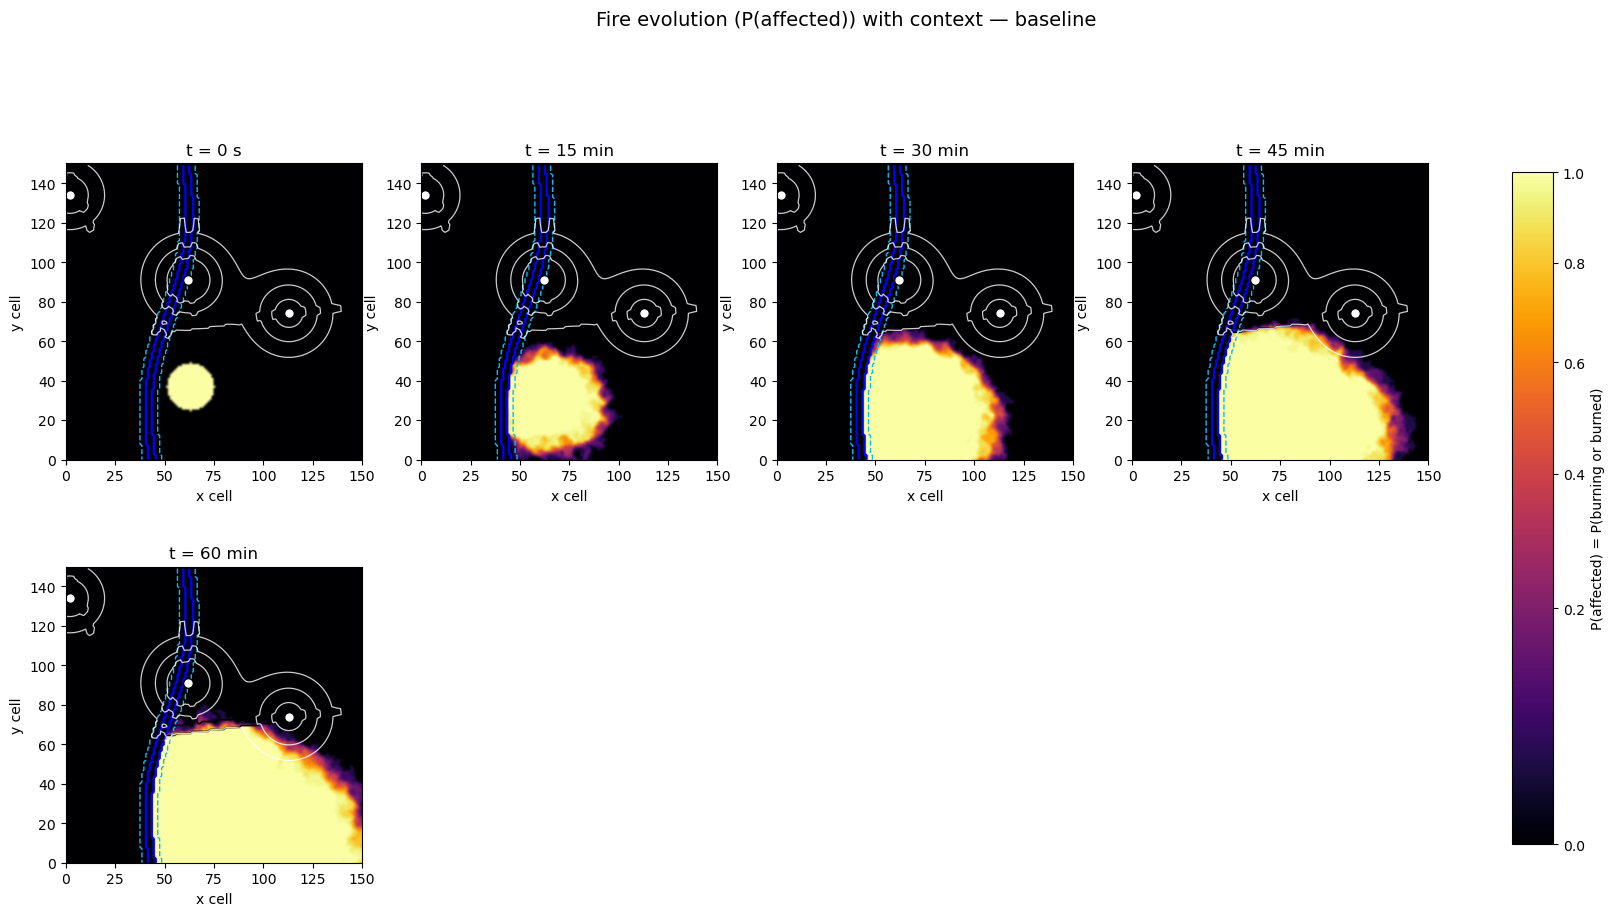

In [7]:
plot_fire_evolution_with_context(
    fire_model,
    init_firestate,
    T_s=60 * 60,
    n_sims=FIDELITY_HIGH,
    drone_params=None,
    dt_snapshot_s=15 * 60,
    seed=1,
    roads_mask=bundle.road_mask,
    river_mask=bundle.river_mask,
    riparian_mask=bundle.riparian_mask,
    town_centers=bundle.town_centers,
    value_map=bundle.env.value,
    diag=bundle.env.diag,
    avoid_burning_drop=bundle.env.avoid_burning_drop,
    burning_prob_threshold=bundle.env.avoid_drop_p_threshold,
    title="Fire evolution (P(affected)) with context — baseline",
)


No drone_params
No drone_params
No drone_params
No drone_params


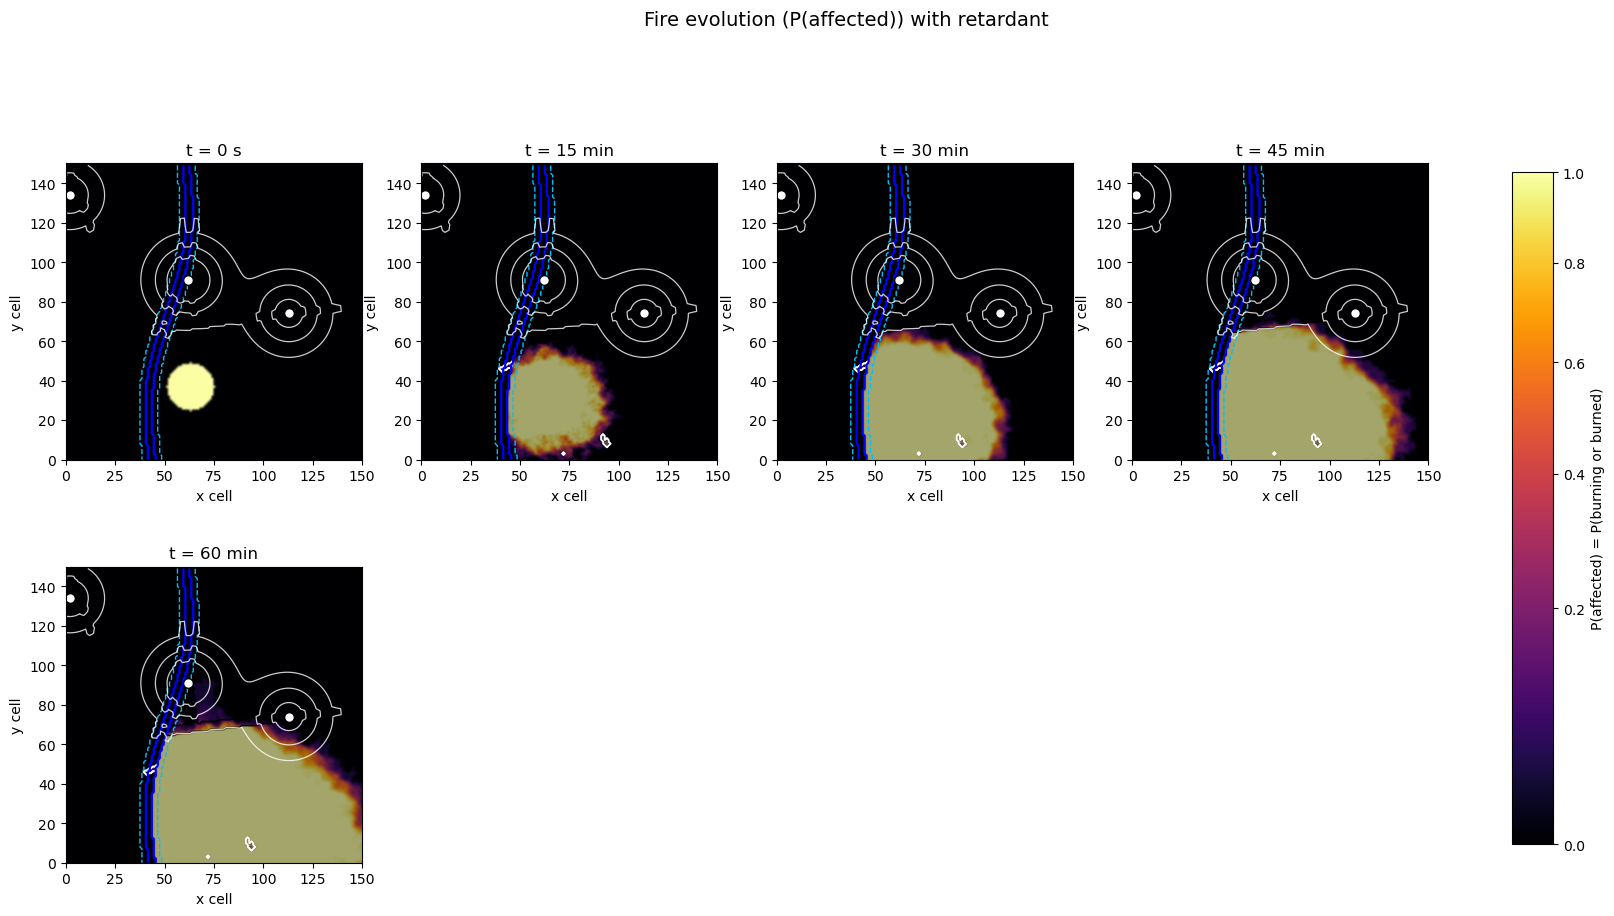

In [8]:
# --- Plot fire evolution with suppression (retardant placements) ---
plot_fire_evolution_with_context(
    fire_model,
    init_firestate,
    T_s=60 * 60,
    n_sims=FIDELITY_HIGH,
    drone_params=best_params_cart,
    dt_snapshot_s=15 * 60,
    seed=1,
    roads_mask=bundle.road_mask,
    river_mask=bundle.river_mask,
    riparian_mask=bundle.riparian_mask,
    town_centers=bundle.town_centers,
    value_map=bundle.env.value,
    diag=bundle.env.diag,
    avoid_burning_drop=bundle.env.avoid_burning_drop,
    burning_prob_threshold=bundle.env.avoid_drop_p_threshold,
    title="Fire evolution (P(affected)) with retardant",
    drop_time_s=DROP_TIME_S,
)

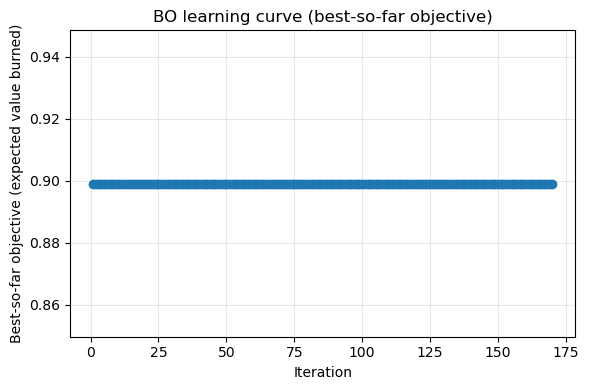

In [9]:
# --- BO learning curve ---
def plot_learning_curve(y_bests, title="BO learning curve (best-so-far objective)"):
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(range(1, len(y_bests) + 1), y_bests, marker="o")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Best-so-far objective (expected value burned)")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_learning_curve(y_bests)
